# Impl√©mentez un mod√®le de scoring

*Notebook mod√©lisation - simulations*

L‚Äôentreprise souhaite mettre en ≈ìuvre un outil de ‚Äúscoring cr√©dit‚Äù pour calculer la probabilit√© qu‚Äôun client rembourse son cr√©dit, puis classifie la demande en cr√©dit accord√© ou refus√©. Elle souhaite donc d√©velopper un algorithme de classification en s‚Äôappuyant sur des sources de donn√©es vari√©es (donn√©es comportementales, donn√©es provenant d'autres institutions financi√®res, etc.).

**Mission :**

- Construire un mod√®le de scoring qui donnera une pr√©diction sur la probabilit√© de faillite d'un client de fa√ßon automatique.

- Analyser les features qui contribuent le plus au mod√®le, d‚Äôune mani√®re g√©n√©rale (feature importance globale) et au niveau d‚Äôun client (feature importance locale), afin, dans un soucis de transparence, de permettre √† un charg√© d‚Äô√©tudes de mieux comprendre le score attribu√© par le mod√®le.

- Mettre en production le mod√®le de scoring de pr√©diction √† l‚Äôaide d‚Äôune API et r√©aliser une interface de test de cette API.

- Mettre en ≈ìuvre une approche globale MLOps de bout en bout, du tracking des exp√©rimentations √† l‚Äôanalyse en production du data drift.
    + Dans le notebook d‚Äôentra√Ænement des mod√®les, g√©n√©rer √† l‚Äôaide de MLFlow un tracking d'exp√©rimentations
    + Lancer l‚Äôinterface web 'UI MLFlow" d'affichage des r√©sultats du tracking
    + R√©aliser avec MLFlow un stockage centralis√© des mod√®les dans un ‚Äúmodel registry‚Äù
    + Tester le serving MLFlow
    + G√©rer le code avec le logiciel de version Git
    + Partager le code sur Github pour assurer une int√©gration continue
    + Utiliser Github Actions pour le d√©ploiement continu et automatis√© du code de l‚ÄôAPI sur le cloud
    + Concevoir des tests unitaires avec Pytest (ou Unittest) et les ex√©cuter de mani√®re automatis√©e lors du build r√©alis√© par Github Actions

## 1 - Pr√©parer l'environnement d'exp√©rimentation

### 1.1 - Imports

In [75]:
import mlflow
import mlflow.tracking
from mlflow.models import infer_signature

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, make_scorer, f1_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # Pipeline de imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler

import lightgbm
from lightgbm import LGBMClassifier

import xgboost
from xgboost import XGBClassifier

import shap
shap.initjs()

from contextlib import contextmanager
from collections import Counter
import time
import timeit

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("mlflow version", mlflow.__version__)
print("sklearn version", sklearn.__version__)
print("lightgbm version", lightgbm.__version__)
print("xgboost version", xgboost.__version__)
print("shap version", shap.__version__)

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_rows = 200
pd.options.display.max_columns = 130

numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
seaborn version 0.13.2
mlflow version 2.20.1
sklearn version 1.6.1
lightgbm version 4.6.0
xgboost version 2.1.3
shap version 0.46.0


### 1.2 - Lancement du serveur MLFlow

Dans le terminal de Powershell Prompt d'Anaconda, lancer cette instruction :

mlflow server --host 127.0.0.1 --port 5000 --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns

Cette commande permet de :
- Stocker les m√©tadonn√©es du Model Registry dans une base de donn√©es locale SQLite.
- Stocker les artefacts (mod√®les, fichiers) en local.

### 1.3 - Initialisation du Tracking MLFlow de test

In [3]:
import os

# Ignorer Git
os.environ['GIT_PYTHON_REFRESH'] = 'quiet'

# V√©rification si la variable d'environnement est bien d√©finie
print(os.environ.get('GIT_PYTHON_REFRESH'))

# D√©finir le serveur de tracking (local ou distant) - ici local
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# D√©marrer une nouvelle exp√©rimentation
mlflow.set_experiment("simulation_scoring_credit_9")

quiet


<Experiment: artifact_location='file:///C:/Users/admin/mlruns/17', creation_time=1740322718731, experiment_id='17', last_update_time=1740322718731, lifecycle_stage='active', name='simulation_scoring_credit_9', tags={}>

### 1.4 - Enregistrer le mod√®le et ses m√©tadonn√©es dans MLFlow

Cr√©ons une fonction :

In [5]:
def tracking_mlflow(tag, model, params, metrics, registered_model_name, X_train, roc_curve_path, pr_curve_path, 
                    val_auc_fic_test, optimal_threshold_test, min_business_score_test, optimal_threshold_train, min_business_score_train):
    
    # D√©marrer une exp√©rimentation dans MLflow
    with mlflow.start_run():
        try:
        
            # Log the hyperparameters
            mlflow.log_params(params)
            
            # Loguer les m√©triques
            for key, value in metrics.items():
                mlflow.log_metric(key, value)
            mlflow.log_metric("val_auc_fic_test", val_auc_fic_test)
            mlflow.log_metric("optimal_threshold_train", optimal_threshold_train)
            mlflow.log_metric("min_business_score_train", min_business_score_train)
            mlflow.log_metric("optimal_threshold_test", optimal_threshold_test)
            mlflow.log_metric("min_business_score_test", min_business_score_test)
            
            # Set a tag that we can use to remind ourselves what this run was for
            mlflow.set_tag(tag[0], tag[1])
        
            # Infer the model signature
            signature = infer_signature(X_train, model.predict(X_train))
            
            # Loguer le mod√®le
            model_info = mlflow.sklearn.log_model(
                sk_model=model,
                artifact_path="iris_model",
                signature=signature,
                input_example=X_train[:5],
                registered_model_name=registered_model_name,
            )

            # Loguer les graphiques dans MLflow
            mlflow.log_artifact(roc_curve_path)
            mlflow.log_artifact(pr_curve_path)
            
            for key, value in metrics.items():
                print(key, ":" , value)

        except Exception as e:
            print(f"‚ùå Erreur dans MLflow : {e}")

        finally:
            mlflow.end_run()  # Assure que la run est bien ferm√©e
    
    print(f"Mod√®le enregistr√© en version {model_info.mlflow_version}")
    
    return model_info

def save_model_mlflow(grid_search, model_name, metrics, roc_curve_path, pr_curve_path, val_auc_fic_test, 
                      optimal_threshold_test, min_business_score_test, optimal_threshold_train, min_business_score_train):
    
    elapsed = round(timeit.default_timer() - start_time, 3)
    print("üìÇ Dur√©e depuis le d√©but : ", elapsed, " - Fin entra√Ænement",  model_name, "...")
    
    # Meilleur mod√®le trouv√©
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Extraction des scores
    results = grid_search.cv_results_
    best_index = grid_search.best_index_
    
    # Pr√©paration des m√©triques √† logger
    metrics_log = {
        "best_business_score": grid_search.best_score_,
        "mean_fit_time": round(results["mean_fit_time"][best_index], 3),
    }
    
    # Ajout des autres scores
    for metric in metrics.keys():
        metrics_log[f"mean_{metric}"] = results[f"mean_test_{metric}"][best_index]
    
    # D√©finition des tags MLflow
    tag = ("model_type", model_name)
    
    # Nom du mod√®le √† enregistrer dans MLflow
    registered_model_name = model_name
    
    elapsed = round(timeit.default_timer() - start_time, 3)
    print("üìÇ Dur√©e depuis le d√©but : ", elapsed, " - D√©but tracking MLFlow",  model_name, "...")
    
    # Appel de la fonction tracking_mlflow
    tracking_mlflow(tag, best_model, best_params, metrics_log, registered_model_name, X_train, roc_curve_path, pr_curve_path, 
                    val_auc_fic_test, optimal_threshold_test, min_business_score_test, optimal_threshold_train, min_business_score_train)
    
    elapsed = round(timeit.default_timer() - start_time, 3)
    print("üìÇ Dur√©e depuis le d√©but : ", elapsed, " - Fin tracking MLFlow",  model_name, "...")
    
    print(f"‚úÖ Fin traitement",  model_name)

### 1.5 - Lancement de l'UI

Pour  la visualisation et la comparaison des exp√©rimentations, ainsi que le stockage de mani√®re centralis√©e des mod√®les.

Cliquer sur ce lien : http://127.0.0.1:5000/

### 1.6 - Charger les donn√©es issues du feature engineering

In [7]:
df = pd.read_csv('C:/Users/admin/Documents/Projets/Projet_7/data_projet/cleaned/data.csv')

print('Training data shape: ', df.shape)
df.head()

Training data shape:  (307507, 395)


SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0    100002.0     1.0           0.0          202500.0    406597.5   
1    100003.0     0.0           0.0          270000.0   1293502.5   
2    100004.0     0.0           0.0           67500.0    135000.0   
3    100006.0     0.0           0.0          135000.0    312682.5   
4    100007.0     0.0           0.0          121500.0    513000.0   

   AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0      24700.5         351000.0                    0.018801     -9461.0   
1      35698.5        1129500.0                    0.003541    -16765.0   
2       6750.0         135000.0                    0.010032    -19046.0   
3      29686.5         297000.0                    0.008019    -19005.0   
4      21865.5         513000.0                    0.028663    -19932.0   

   DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
0         -637.0            -3648.0          -2120.0         1.0   
1        -1188.0            -1186.0           -291.0         1.0   
2         -225.0            -4260.0          -2531.0         1.0   
3        -3039.0            -9833.0          -2437.0         1.0   
4        -3038.0            -4311.0          -3458.0         1.0   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0             1.0              0.0               1.0         1.0         0.0   
1             1.0              0.0               1.0         1.0         0.0   
2             1.0              1.0               1.0         1.0         0.0   
3             1.0              0.0               1.0         0.0         0.0   
4             1.0              0.0               1.0         0.0         0.0   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0              1.0                   2.0                          2.0   
1              2.0                   1.0                          1.0   
2              1.0                   2.0                          2.0   
3              2.0                   2.0                          2.0   
4              1.0                   2.0                          2.0   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                     10.0                         0.0   
1                     11.0                         0.0   
2                      9.0                         0.0   
3                     17.0                         0.0   
4                     11.0                         0.0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                         0.0                          0.0   
1                         0.0                          0.0   
2                         0.0                          0.0   
3                         0.0                          0.0   
4                         0.0                          0.0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                     0.0                     0.0                      0.0   
1                     0.0                     0.0                      0.0   
2                     0.0                     0.0                      0.0   
3                     0.0                     0.0                      0.0   
4                     0.0                     1.0                      1.0   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.083037      0.262949      0.139376          0.0247            0.0369   
1      0.311267      0.622246      0.535276          0.0959            0.0529   
2      0.505998      0.555912      0.729567          0.0876            0.0763   
3      0.505998      0.650442      0.535276          0.0876            0.0763   
4      0.505998      0.322738      0.535276          0.0876            0.0763   

   YEARS_BEGINEXPLUATATION_AVG  ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  \
0                       0.9722           0.00      

In [8]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [14]:
# Missing values statistics
missing_values = missing_values_table(df)
missing_values.head(130)

Your selected dataframe has 395 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Bien. Aucune valeur manquante.

### 1.7 - Cr√©er les fonctions communes

In [9]:
def print_result_CV_as_dataframe(grid_search, scoring):

    # Liste pour stocker les r√©sultats
    results = []
    
    # Affichage des r√©sultats de la validation crois√©e
    print("R√©sultats de la validation crois√©e :")
    
    for score_name in scoring.keys():
        for mean, std, params, mean_fit_time in zip(
            grid_search.cv_results_[f'mean_test_{score_name}'],  # Score moyen pour chaque m√©trique
            grid_search.cv_results_[f'std_test_{score_name}'],   # √âcart-type du score
            grid_search.cv_results_['params'],                   # Valeurs des hyperparam√®tres
            grid_search.cv_results_['mean_fit_time']             # Temps moyen d'entra√Ænement
        ):
            # Ajout des r√©sultats sous forme de dictionnaire
            results.append({
                "score_name": score_name,
                "mean_score": mean,
                "std_score": std,
                "params": params,
                "mean_fit_time": mean_fit_time
            })

    # Transformation en DataFrame
    df_results = pd.DataFrame(results)

    # Convertir 'params' en string pour affichage correct
    df_results['params'] = df_results['params'].apply(str)

    # Transformation avec pivot pour structurer les donn√©es
    df_results = df_results.pivot(
        index='params',                        # Les param√®tres deviennent l'index
        columns='score_name',                   # Les m√©triques deviennent des colonnes
        values=['mean_score', 'mean_fit_time']  # Les valeurs √† afficher
    ).reset_index()

    # Aplatir les colonnes multi-index√©es
    df_results.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_results.columns.values]

    # Identifier la meilleure m√©trique de tri (prendre la premi√®re de `scoring`)
    main_metric = list(scoring.keys())[0]  # Prend la premi√®re m√©trique comme r√©f√©rence
    main_metric_col = f"mean_score_{main_metric}"

    # Trier le DataFrame selon cette m√©trique (du plus grand au plus petit)
    df_results.sort_values(by=main_metric_col, ascending=False, inplace=True)

    # Suppression des colonnes superflues
    fit_time_columns = [col for col in df_results.columns if "mean_fit_time_" in col and col != "mean_fit_time"]
    df_results.drop(columns=fit_time_columns, inplace=True)

    # R√©initialisation de l'index
    df_results = df_results.reset_index(drop=True)

    return df_results

# fonction bas√©e sur le fichier train complet
def print_ROC_curve(best_model, X_train, y_train, X_test, y_test):

    # Pr√©dire les probabilit√©s pour la classe positive
    y_scores_train = best_model.predict_proba(X_train)[:, 1]
    y_scores_test = best_model.predict_proba(X_test)[:, 1]

    # Calculer la courbe ROC
    fpr_train, tpr_train, _ = roc_curve(y_train, y_scores_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_scores_test)

    # Calculer l'AUC
    auc_train = auc(fpr_train, tpr_train)
    auc_test = auc(fpr_test, tpr_test)

    # Tracer les courbes ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train ROC (AUC = {auc_train:.2f})')
    plt.plot(fpr_test, tpr_test, color='red', lw=2, label=f'Test ROC (AUC = {auc_test:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Ligne de r√©f√©rence
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Train vs Test")
    plt.legend(loc="lower right")

    # Retourner le plt pour l'enregistrement dans MLFlow
    return plt

# fonction bas√©e sur les valeurs de la validation crois√©e
def print_ROC_curve_cv(best_model, X_train, y_train, X_test, y_test, cv=5):
    
    # Validation crois√©e avec pr√©diction des probabilit√©s sur chaque fold
    cv_strategy = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    y_scores_cv = cross_val_predict(best_model, X_train, y_train, cv=cv_strategy, method="predict_proba")[:, 1]

    # Pr√©dire les probabilit√©s pour le fichier test
    y_scores_test = best_model.predict_proba(X_test)[:, 1]

    # Calculer les courbes ROC
    fpr_cv, tpr_cv, _ = roc_curve(y_train, y_scores_cv)  # Validation crois√©e
    fpr_test, tpr_test, _ = roc_curve(y_test, y_scores_test)

    # Calculer les AUC
    auc_cv = auc(fpr_cv, tpr_cv)
    auc_test = auc(fpr_test, tpr_test)

    # Tracer les courbes ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_cv, tpr_cv, color='green', lw=2, label=f'CV ROC (AUC = {auc_cv:.2f})')
    plt.plot(fpr_test, tpr_test, color='blue', lw=2, label=f'Test ROC (AUC = {auc_test:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Ligne de r√©f√©rence

    # Mise en forme
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Validation (CV) vs Test")
    plt.legend(loc="lower right")

    return plt


def print_PR_curve(best_model, X_train, y_train, X_test, y_test):

    # Pr√©dire les probabilit√©s pour la classe positive
    y_scores_train = best_model.predict_proba(X_train)[:, 1]
    y_scores_test = best_model.predict_proba(X_test)[:, 1]

    # Calcul des courbes PR
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_scores_train)
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_scores_test)

    # Calcul des AUC PR
    auc_pr_train = auc(recall_train, precision_train)
    auc_pr_test = auc(recall_test, precision_test)

    # Tracer les courbes Precision-Recall
    plt.figure(figsize=(8, 6))
    plt.plot(recall_train, precision_train, color='blue', lw=2, label=f'Train PR (AUC = {auc_pr_train:.2f})')
    plt.plot(recall_test, precision_test, color='red', lw=2, label=f'Test PR (AUC = {auc_pr_test:.2f})')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve - Train vs Test")
    plt.legend(loc="lower left")
    plt.grid()

    # Retourner le plt pour enregistrement (MLFlow ou autre)
    return plt

def plot_histogram_with_threshold(y_true, y_pred_proba, threshold):
    """
    Trace un histogramme des scores de pr√©diction pour les classes 0 et 1,
    avec une ligne verticale indiquant le seuil de d√©cision.
    """
    # S√©parer les pr√©dictions en fonction des classes r√©elles
    scores_class_0 = y_pred_proba[y_true == 0]  # Scores pour la classe 0 (pr√™ts accord√©s)
    scores_class_1 = y_pred_proba[y_true == 1]  # Scores pour la classe 1 (pr√™ts refus√©s)

    # Tracer les histogrammes
    plt.figure(figsize=(8, 6))
    plt.hist(scores_class_0, bins=50, alpha=0.6, label="Classe 0 (pr√™ts accord√©s)", color="blue")
    plt.hist(scores_class_1, bins=50, alpha=0.6, label="Classe 1 (pr√™ts refus√©s)", color="red")

    # Ajouter la ligne verticale pour le seuil optimal
    plt.axvline(threshold, color="black", linestyle="--", label=f"Seuil optimal = {threshold:.4f}")

    # Labels et titre
    plt.xlabel("Probabilit√© pr√©dite")
    plt.ylabel("Densit√©")
    plt.title("Distribution des probabilit√©s de pr√©diction par classe")
    plt.legend()
    plt.show()

def plot_bar_histogram(y_true, y_pred_proba, threshold):
    """
    Trace un histogramme avec seulement deux barres :
    - Une pour la classe 0 (pr√™ts accord√©s)
    - Une pour la classe 1 (pr√™ts refus√©s)
    """
    # Calculer la moyenne des probabilit√©s pr√©dites pour chaque classe
    mean_score_0 = np.mean(y_pred_proba[y_true == 0])  # Moyenne des scores pour la classe 0
    mean_score_1 = np.mean(y_pred_proba[y_true == 1])  # Moyenne des scores pour la classe 1

    # Cr√©ation du graphique
    plt.figure(figsize=(6, 5))
    plt.bar(["Classe 0 (pr√™ts accord√©s)", "Classe 1 (pr√™ts refus√©s)"], [mean_score_0, mean_score_1], color=["blue", "red"], alpha=0.7)

    # Ajouter une ligne pour le seuil optimal
    plt.axhline(y=threshold, color="black", linestyle="--", label=f"Seuil optimal = {threshold:.4f}")

    # Labels et titre
    plt.ylabel("Probabilit√© moyenne pr√©dite")
    plt.title("Moyenne des scores pr√©dits pour chaque classe")
    plt.legend()
    plt.show()

def plot_auc_folds(best_model, X, y, cv):
    auc_scores = []  # Stocker les AUC pour chaque fold
    fold_numbers = np.arange(1, cv.get_n_splits() + 1)  # Liste des folds (1, 2, 3, ...)

    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Pr√©dictions des probabilit√©s pour la classe positive (1)
        y_scores = best_model.predict_proba(X_test)[:, 1]

        # Calcul de l'AUC
        auc = roc_auc_score(y_test, y_scores)
        auc_scores.append(auc)

    # Tracer l'√©volution de l'AUC
    plt.figure(figsize=(8, 5))
    plt.plot(fold_numbers, auc_scores, marker='o', linestyle='-', color='b', label='AUC par fold')
    plt.axhline(y=np.mean(auc_scores), color='r', linestyle='--', label=f'Moyenne AUC: {np.mean(auc_scores):.3f}')
    plt.xlabel("Num√©ro du Fold")
    plt.ylabel("AUC Score")
    plt.title("Variation de l'AUC par Fold")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_roc_folds(best_model, X, y, cv):
    """
    Trace les courbes ROC des diff√©rents splits (folds) de la cross-validation.
    
    Parameters:
        - best_model: best_model du GridSearchCV d√©j√† entra√Æn√©.
        - X: Features utilis√©es pour la validation crois√©e.
        - y: Labels r√©els.
        - cv: Strat√©gie de validation crois√©e (ex: StratifiedKFold).
    """
    mean_fpr = np.linspace(0, 1, 100)  # Points communs pour interpoler les courbes ROC
    tprs = []
    aucs = []

    plt.figure(figsize=(8, 6))
    
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Pr√©dictions des probabilit√©s pour la classe positive (1)
        y_scores = best_model.predict_proba(X_test)[:, 1]

        # Calculer la courbe ROC
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)

        # Sauvegarder les TPR interpol√©s pour la moyenne
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        aucs.append(roc_auc)

        # Tracer la courbe ROC du fold
        plt.plot(fpr, tpr, alpha=0.3, label=f"Fold {fold_idx+1} (AUC = {roc_auc:.2f})")

    # Tracer la moyenne des courbes ROC
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    plt.plot(mean_fpr, mean_tpr, color="blue", label=f"Moyenne ROC (AUC = {mean_auc:.2f} ¬± {std_auc:.2f})", lw=2)

    # Ligne diagonale
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

    # Param√®tres du graphe
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Courbe ROC par Fold (Cross-validation)")
    plt.legend()
    plt.show()

## 2 - Cr√©er un score m√©tier pour l'entra√Ænement des mod√®les

### 2.1 - Cr√©er le score m√©tier et le score pour le seuil

In [10]:
# Calculer le co√ªt
def calculate_errors_cost(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return 10 * fn + fp

# On transforme le score en n√©gatif pour que GridSearchCV le minimise
neg_business_scorer = make_scorer(calculate_errors_cost, greater_is_better=False)

# Scorer pour renvoyer le seuil utilis√©
#def get_threshold_score(y_true, y_proba, threshold=0.5):
#    y_pred = (y_proba >= threshold).astype(int)
#    return threshold  # Retourne le seuil utilis√©

#threshold_scorer = make_scorer(get_threshold_score, needs_proba=True)

Test de la fonction : 

In [21]:
y_test_sample = [0, 1, 1, 0, 1, 0, 0, 1, 1, 0]
y_pred_sample = [0, 0, 1, 0, 1, 0, 1, 1, 1, 0]

print("R√©sultat de calculate_errors_cost:", calculate_errors_cost(y_test_sample, y_pred_sample))

R√©sultat de calculate_errors_cost: 11


### 2.2 - Cr√©er une fonction pour trouver le seuil optimal

Le seuil optimal est la valeur √† partir de laquelle on d√©cide si un client doit obtenir ou non un cr√©dit, bas√© sur la probabilit√© pr√©dite par le mod√®le. Le but est de trouver un seuil qui minimise le co√ªt m√©tier, c'est-√†-dire le co√ªt total des erreurs de pr√©diction en tenant compte des faux positifs (FP) et des faux n√©gatifs (FN), o√π les faux n√©gatifs sont 10 fois plus co√ªteux.

Le seuil optimal est celui qui donne le co√ªt total le plus bas.

In [11]:
def find_optimal_threshold_business(y_true, y_scores, calculate_errors_cost):
    # Calcul de la courbe PR pour obtenir les seuils possibles
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

    # Ajouter le seuil 0.5 au cas o√π il ne serait pas dans la liste
    thresholds = np.append(thresholds, 0.5)

    # Calculer `business_score` pour chaque seuil
    business_scores = []
    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)  # Binarisation selon le seuil
        score = calculate_errors_cost(y_true, y_pred)
        business_scores.append(score)

    # Trouver le seuil qui minimise le `business_score`
    optimal_idx = np.argmin(business_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    return optimal_threshold, business_scores[optimal_idx]

## 3 - Simuler et comparer plusieurs mod√®les avec undersampling

Pour corriger le d√©s√©quilibre entre le nombre de bons et de moins bons clients, 3 solutions peuvent √™tre utilis√©es :

- SMOTE : qui permet de g√©n√®rer des exemples synth√©tiques pour la classe minoritaire, en cr√©ant de nouvelles instances en interpolant entre les exemples existants de la classe minoritaire.

  - j'ai commenc√© avec cette m√©thode, mais les temps de traitement √©taient trop long, et faisait planter mon PC √† cause des 300 000 lignes qu'il g√©n√©r√®re pour le r√©quilibrage. 


- Ou par ajustement des poids des classes par param√©trage des mod√®les de type "class_weight"
  
  - Logistic Regression avec class_weight="balanced"
  
  - Random Forest avec class_weight="balanced"
  
  - Decision Tree avec class_weight="balanced"
  
  - XGBoost avec scale_pos_weight
  
  - LightGBM avec is_unbalance=True ou scale_pos_weight

- Ou par Undersampling (sous-√©chantillonage) : r√©duire la taille de la classe majoritaire pour √©quilibrer les proportions. L'avantage c'est qu'elle r√©duit la taille du dataset, ce qui permet un gain de rapidit√© pour des premi√®res simulation. Je vais donc commencer les simulations avec cette m√©thodes, pour faire une 1ere s√©lection des mod√®les, et ensuite je travaillerais avec SMOTE (oversampling) pour l'affinage.

### 3.1 - Pr√©parer le dataset avec undersampling

Distribution apr√®s sous-√©chantillonnage : Counter({0.0: 24825, 1.0: 24825})
taille X_train :  (39720, 394)
taille y_train :  (39720,)
taille X_test :  (9930, 394)
taille y_test :  (9930,)


<Axes: ylabel='Frequency'>

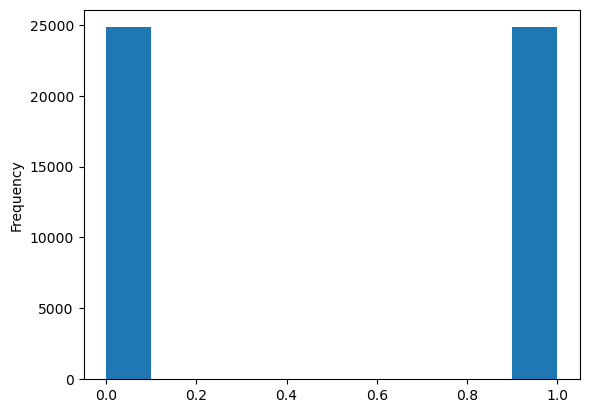

In [17]:
# D√©finition des features et de la target
X = df.drop(columns=["TARGET"])  # Features
y = df["TARGET"]  # Variable cible

# sous-√©chantillonage
X_resampled, y_resampled = RandomUnderSampler().fit_resample(X, y)
print(f"Distribution apr√®s sous-√©chantillonnage : {Counter(y_resampled)}")

# Centrage et r√©duction des donn√©es
X_scale = StandardScaler().fit_transform(X_resampled)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_scale, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

print("taille X_train : ", X_train.shape)
print("taille y_train : ", y_train.shape)
print("taille X_test : ", X_test.shape)
print("taille y_test : ", y_test.shape)

y_resampled.plot.hist()

In [19]:
# Scorer personnalis√© pour calculer l'AUC (besoin des probabilit√©s)
#def auc_scorer(y_true, y_proba):
#    return roc_auc_score(y_true, y_proba)

# `needs_proba=True` pour utiliser `predict_proba`
#auc_scorer = make_scorer(auc_scorer, needs_proba=True)

# Scorers personnalis√©s
metrics = {
    "business_score": neg_business_scorer,
    "accuracy": make_scorer(accuracy_score),  # Accuracy classique,
    "AUC": "roc_auc",
    "f1_macro": make_scorer(f1_score, average="macro"),  # F1-score macro
    "precision": make_scorer(precision_score, average="macro"),  # Pr√©cision macro
    "recall": make_scorer(recall_score, average="macro"),  # Rappel macro
}

### 3.2 - Simuler avec DumyClassifier (Baseline)

In [29]:
print("üìÇ Lancement du traitement DummyClassifier...")
start_time = timeit.default_timer()

# D√©finition des param√®tres √† tester
param_grid = {
    'strategy': ['most_frequent']
}

# Initialisation du mod√®le
dummy_clf = DummyClassifier()

# GridSearchCV avec plusieurs scores
grid_search = GridSearchCV(dummy_clf, param_grid, scoring=metrics, refit="business_score", cv=5, n_jobs=1, verbose=1)

# Ex√©cution de la recherche
grid_search.fit(X_train, y_train)

# S√©lectionner le meilleur mod√®le de GridSearchCV
best_model = grid_search.best_estimator_

# Tracer la courbe ROC Curve
plt = print_ROC_curve(best_model, X_train, y_train, X_test, y_test)

# Sauvegarder le graphique dans un fichier
roc_curve_path = "roc_curve.png"
plt.savefig(roc_curve_path)
plt.close()

# Tracer la courbe PR Curve
plt = print_ROC_curve_cv(best_model, X_train, y_train, X_test, y_test, cv=5)

# Sauvegarder le graphique dans un fichier
pr_curve_path = "pr_curve.png"
plt.savefig(pr_curve_path)
plt.close()

# Faire des pr√©dictions de probabilit√© sur l'ensemble de test
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]  # Probabilit√©s pour la classe positive

# Faire des pr√©dictions de probabilit√© sur l'ensemble de train
y_pred_proba_train = best_model.predict_proba(X_train)[:, 1]  # Probabilit√©s pour la classe positive

# Calculer l'AUC
auc_score_test = roc_auc_score(y_test, y_pred_proba_test)

# Calculer le seuil optimal test et train
optimal_threshold_train, min_business_score_train = find_optimal_threshold_business(y_train, y_pred_proba_train, calculate_errors_cost)
print("üìÇ", f"Seuil optimal train: {optimal_threshold_train:.4f}, Business Score minimal : {min_business_score_train:.4f}")
optimal_threshold_test, min_business_score_test = find_optimal_threshold_business(y_test, y_pred_proba_test, calculate_errors_cost)
print("üìÇ", f"Seuil optimal test: {optimal_threshold_test:.4f}, Business Score minimal : {min_business_score_test:.4f}")

# Sauvegarder les informations dans MLFow
save_model_mlflow(grid_search, "DummyClassifier_gridSearchCV", metrics, roc_curve_path, pr_curve_path, auc_score_test, optimal_threshold_test, min_business_score_test,
                 optimal_threshold_train, min_business_score_train)

# Supprimer le fichier temporaire
os.remove(roc_curve_path)
os.remove(pr_curve_path)

üìÇ Lancement du traitement DummyClassifier...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
üìÇ Seuil optimal train: 0.0000, Business Score minimal : 19860.0000
üìÇ Seuil optimal test: 0.0000, Business Score minimal : 4965.0000
üìÇ Dur√©e depuis le d√©but :  2.882  - Fin entra√Ænement DummyClassifier_gridSearchCV ...
üìÇ Dur√©e depuis le d√©but :  2.882  - D√©but tracking MLFlow DummyClassifier_gridSearchCV ...


Registered model 'DummyClassifier_gridSearchCV' already exists. Creating a new version of this model...
2025/02/23 15:59:36 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DummyClassifier_gridSearchCV, version 3


best_business_score : -39720.0
mean_fit_time : 0.142
mean_business_score : -39720.0
mean_accuracy : 0.5
mean_AUC : 0.5
mean_f1_macro : 0.3333333333333333
mean_precision : 0.25
mean_recall : 0.5
üèÉ View run fearless-stag-893 at: http://127.0.0.1:5000/#/experiments/17/runs/ee1d9d6f3fc84f818379448405ff02bd
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/17
Mod√®le enregistr√© en version 2.20.1
üìÇ Dur√©e depuis le d√©but :  22.021  - Fin tracking MLFlow DummyClassifier_gridSearchCV ...
‚úÖ Fin traitement DummyClassifier_gridSearchCV


Created version '3' of model 'DummyClassifier_gridSearchCV'.


**Affichons la courbe ROC AUC**

Text(0, 0.5, 'True Positive Rate')

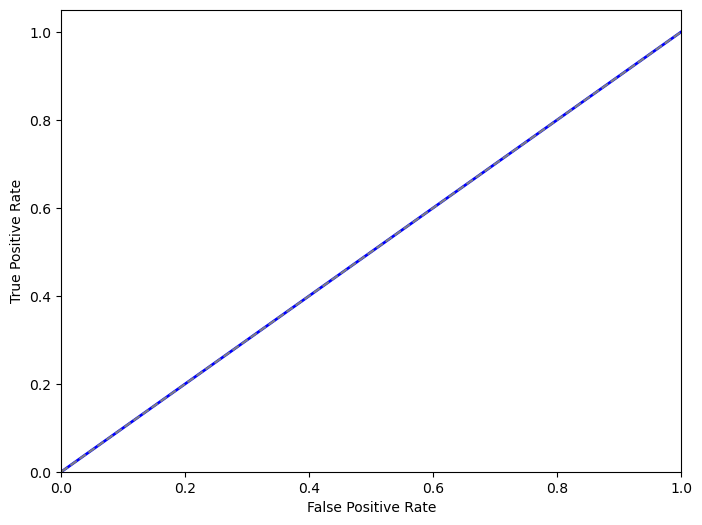

In [31]:
# 2. Pr√©dire les probabilit√©s sur le jeu de test
y_scores = best_model.predict_proba(X_test)[:, 1]  # Probabilit√© pour la classe positive

# 3. Calculer la courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# 4. Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Ligne de r√©f√©rence
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

La courbe ROC et la diagonale se confondent. C'est normal car le DummyClassifier avec le param√®tre "most_frequent" avait une chance sur 2 de se tromper. Et comme les donn√©es en entr√©es sont √©quilibr√©s, on observe ce comportement.

<module 'matplotlib.pyplot' from 'C:\\Users\\admin\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

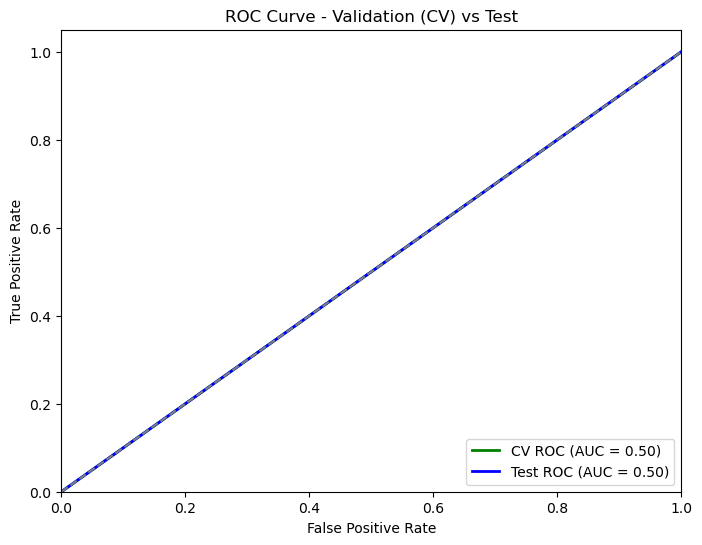

In [33]:
print_ROC_curve_cv(best_model, X_train, y_train, X_test, y_test, cv=5)

**Affichons la courbe PR**

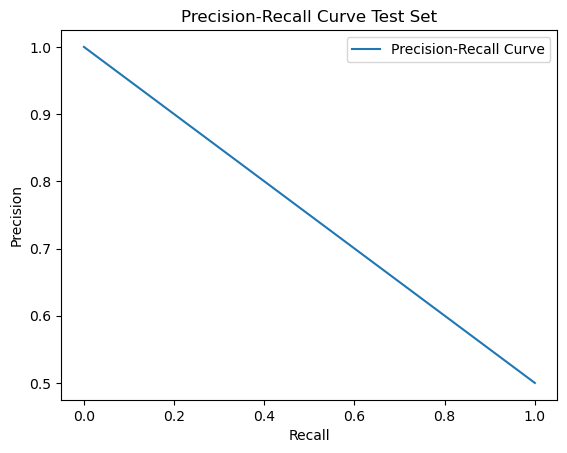

In [35]:
y_scores_test = best_model.predict_proba(X_test)[:, 1]

precision_test, recall_test, thresholds_test = precision_recall_curve(
    y_test, y_scores_test
)

plt.plot(recall_test, precision_test, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Test Set")
plt.legend()
plt.show()

auc_test = auc(recall_test, precision_test)

### 3.3 - Simuler avec LogisticRegression

In [37]:
print("üìÇ Lancement du traitement LogisticRegression...")
start_time = timeit.default_timer()

# Initialisation du mod√®le
base_model = LogisticRegression(random_state=42)  # Utilisation d'un solver adapt√©

# Param√®tres √† tester dans GridSearchCV
param_grid = {
    "C": [0.01, 1, 100],  # R√©gularisation
    "penalty": ["l1", "l2"],
    "solver": ["liblinear"]
}

grid_search = GridSearchCV(
    base_model,
    param_grid=param_grid,
    scoring=metrics,
    refit="business_score",
    cv=5,
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)


# S√©lectionner le meilleur mod√®le de GridSearchCV
best_model = grid_search.best_estimator_

# Tracer la courbe ROC Curve
plt = print_ROC_curve(best_model, X_train, y_train, X_test, y_test)

# Sauvegarder le graphique dans un fichier
roc_curve_path = "roc_curve.png"
plt.savefig(roc_curve_path)
plt.close()

# Tracer la courbe PR Curve
plt = print_ROC_curve_cv(best_model, X_train, y_train, X_test, y_test, cv=5)

# Sauvegarder le graphique dans un fichier
pr_curve_path = "pr_curve.png"
plt.savefig(pr_curve_path)
plt.close()

# Faire des pr√©dictions de probabilit√© sur l'ensemble de test
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]  # Probabilit√©s pour la classe positive

# Faire des pr√©dictions de probabilit√© sur l'ensemble de train
y_pred_proba_train = best_model.predict_proba(X_train)[:, 1]  # Probabilit√©s pour la classe positive

# Calculer l'AUC
auc_score_test = roc_auc_score(y_test, y_pred_proba_test)

# Calculer le seuil optimal test et train
optimal_threshold_train, min_business_score_train = find_optimal_threshold_business(y_train, y_pred_proba_train, calculate_errors_cost)
print("üìÇ", f"Seuil optimal train: {optimal_threshold_train:.4f}, Business Score minimal : {min_business_score_train:.4f}")

optimal_threshold_test, min_business_score_test = find_optimal_threshold_business(y_test, y_pred_proba_test, calculate_errors_cost)
print("üìÇ", f"Seuil optimal test: {optimal_threshold_test:.4f}, Business Score minimal : {min_business_score_test:.4f}")

save_model_mlflow(grid_search, "LogisticRegression_gridSearchCV", metrics, roc_curve_path, pr_curve_path, auc_score_test, optimal_threshold_test, min_business_score_test,
                 optimal_threshold_train, min_business_score_train)

# Supprimer le fichier temporaire
os.remove(roc_curve_path)
os.remove(pr_curve_path)

üìÇ Lancement du traitement LogisticRegression...
üìÇ Seuil optimal train: 0.0445, Business Score minimal : 19754.0000
üìÇ Seuil optimal test: 0.0416, Business Score minimal : 4935.0000
üìÇ Dur√©e depuis le d√©but :  5260.264  - Fin entra√Ænement LogisticRegression_gridSearchCV ...
üìÇ Dur√©e depuis le d√©but :  5260.264  - D√©but tracking MLFlow LogisticRegression_gridSearchCV ...


Registered model 'LogisticRegression_gridSearchCV' already exists. Creating a new version of this model...
2025/02/23 17:27:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegression_gridSearchCV, version 23


best_business_score : -13282.4
mean_fit_time : 198.711
mean_business_score : -13282.4
mean_accuracy : 0.696122860020141
mean_AUC : 0.7625634603351354
mean_f1_macro : 0.6961182628440326
mean_precision : 0.6961347328546077
mean_recall : 0.696122860020141
üèÉ View run sedate-roo-810 at: http://127.0.0.1:5000/#/experiments/17/runs/c6ffd7bb0f4a480ba1debc5da97d3d60
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/17
Mod√®le enregistr√© en version 2.20.1
üìÇ Dur√©e depuis le d√©but :  5271.876  - Fin tracking MLFlow LogisticRegression_gridSearchCV ...
‚úÖ Fin traitement LogisticRegression_gridSearchCV


Created version '23' of model 'LogisticRegression_gridSearchCV'.


In [38]:
print_result_CV_as_dataframe(grid_search, metrics) 

R√©sultats de la validation crois√©e :


params_  mean_score_AUC  \
0   {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}        0.762563   
1  {'C': 100, 'penalty': 'l2', 'solver': 'libline...        0.762939   
2   {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}        0.762533   
3  {'C': 100, 'penalty': 'l1', 'solver': 'libline...        0.762687   
4  {'C': 0.01, 'penalty': 'l2', 'solver': 'liblin...        0.761430   
5  {'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...        0.757803   

   mean_score_accuracy  mean_score_business_score  mean_score_f1_macro  \
0             0.696123                   -13282.4             0.696118   
1             0.695972                   -13298.0             0.695969   
2             0.695947                   -13298.2             0.695942   
3             0.695871                   -13300.6             0.695867   
4             0.693882                   -13377.6             0.693878   
5             0.692095                   -13642.0             0.692084   

   mean_score_precision  mean_score_recall  
0              0.696135           0.696123  
1              0.695980           0.695972  
2              0.695959           0.695947  
3              0.695881           0.695871  
4              0.693892           0.693882  
5              0.692122           0.692095

**Tra√ßons l'histogramme des probabilit√©s:**

Un bon moyen d'analyser les performances d'un mod√®le de classification consiste √† tracer l'histogramme des probabilit√©s des pr√©dictions.

<Axes: ylabel='Count'>

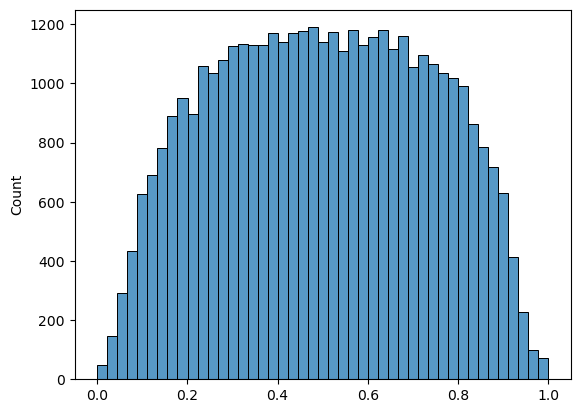

In [40]:
# R√©cup√©rer les probabilit√©s pr√©dites sur un jeu d'entra√Ænement
y_proba_train = best_model.predict_proba(X_train)[:,1]

# Afficher l'histogramme
sns.histplot(y_proba_train)

<Axes: ylabel='Count'>

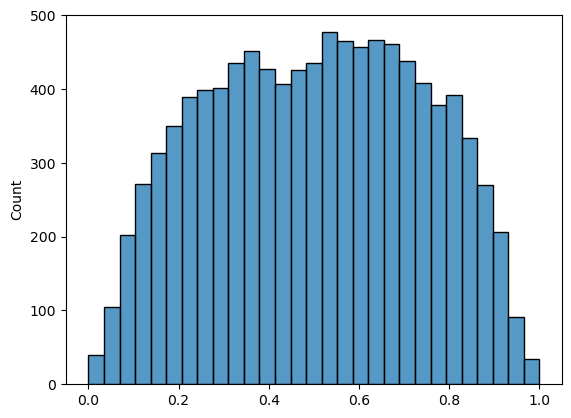

In [41]:
# R√©cup√©rer les probabilit√©s pr√©dites sur un jeu de test
y_proba_test = best_model.predict_proba(X_test)[:,1]

# Afficher l'histogramme
sns.histplot(y_proba_test)

On observe que les probabilit√©s de pr√©dictions ne sont pas clairement espac√©s. La distribution suit la loi normal. C'est clairement l'histogramme d'un mod√®le incertain.

**Affichons la courbe ROC**

<module 'matplotlib.pyplot' from 'C:\\Users\\admin\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

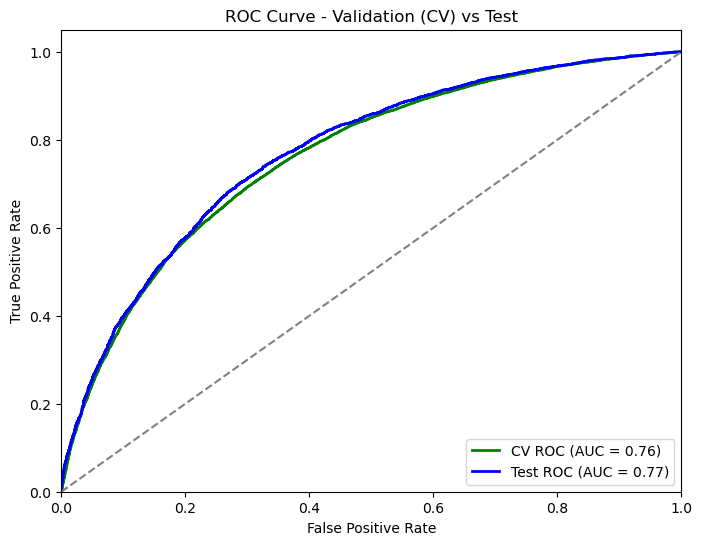

In [43]:
print_ROC_curve_cv(best_model, X_train, y_train, X_test, y_test, cv=5)

**Regardons l'AUC sur le fichier de test**

In [45]:
# S√©lectionner le meilleur mod√®le de GridSearchCV
best_model = grid_search.best_estimator_

# Faire des pr√©dictions de probabilit√© sur l'ensemble de test
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]  # Probabilit√©s pour la classe positive

# Calculer l'AUC
auc_score = roc_auc_score(y_test, y_pred_proba_test)

print("L'AUC sur le fichier de test est : ", auc_score)

L'AUC sur le fichier de test est :  0.77059342892696


Il est tr√®s l√©g√®rement sup√©rieur au meilleur r√©sultat d'entra√Ænement qui √©tait de 0.76.

**Regardons la courbe PR**

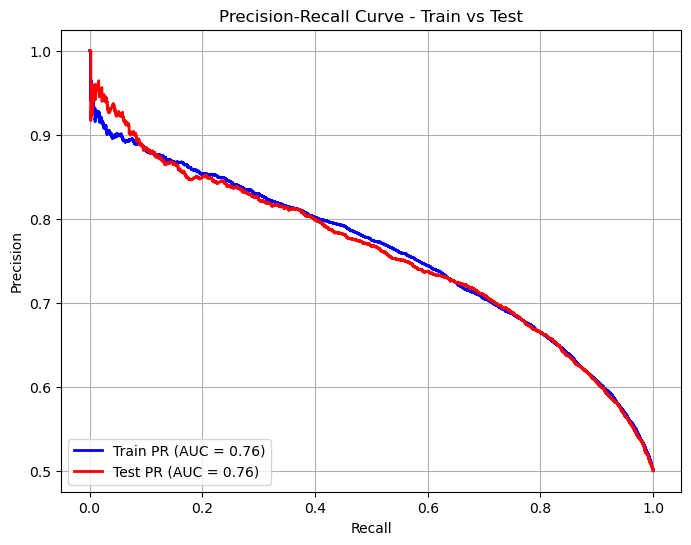

In [48]:
# Pr√©dire les probabilit√©s pour la classe positive
y_scores_train = best_model.predict_proba(X_train)[:, 1]
y_scores_test = best_model.predict_proba(X_test)[:, 1]

# Calcul des courbes PR
precision_train, recall_train, _ = precision_recall_curve(y_train, y_scores_train)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_scores_test)

# Calcul des AUC PR
auc_pr_train = auc(recall_train, precision_train)
auc_pr_test = auc(recall_test, precision_test)

# Tracer les courbes Precision-Recall
plt.figure(figsize=(8, 6))
plt.plot(recall_train, precision_train, color='blue', lw=2, label=f'Train PR (AUC = {auc_pr_train:.2f})')
plt.plot(recall_test, precision_test, color='red', lw=2, label=f'Test PR (AUC = {auc_pr_test:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Train vs Test")
plt.legend(loc="lower left")
plt.grid()

**Regardons la stabilit√© de l'AUC du meilleur mod√®le sur chaque fold du meilleur mod√®le**

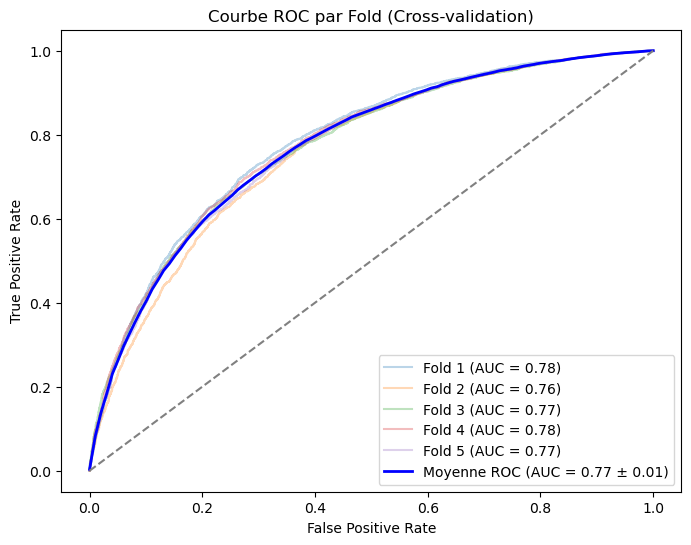

In [50]:
# Utilisation avec un GridSearchCV entra√Æn√©
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds stratifi√©s
plot_roc_folds(grid_search, X_train, y_train, cv)

**Affichons la matrice de confusion avec le seuil optimal**

Sur le fichier d'entra√Ænement :

Seuil optimal train :  0.0444977026396394


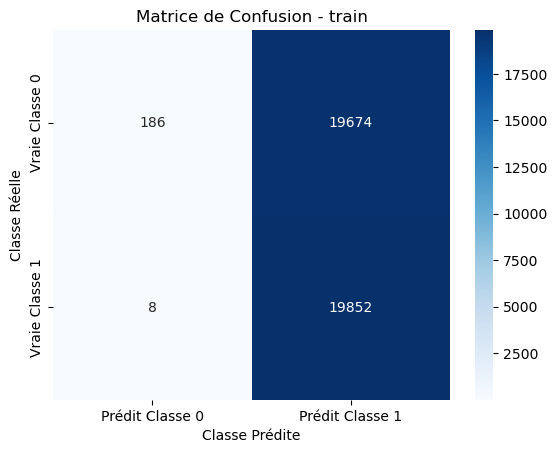

In [52]:
print("Seuil optimal train : ", optimal_threshold_train)

# Appliquer le Seuil Optimal
y_pred = (y_proba_train >= optimal_threshold_train).astype(int)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_train, y_pred)

# Transformation en DataFrame avec des labels
df_cm = pd.DataFrame(cm, index=["Vraie Classe 0", "Vraie Classe 1"], 
                         columns=["Pr√©dit Classe 0", "Pr√©dit Classe 1"])

sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Classe R√©elle")
plt.xlabel("Classe Pr√©dite")
plt.title("Matrice de Confusion - train")
plt.show()

Sur le fichier de test:

Seuil optimal test :  0.04158866266805545


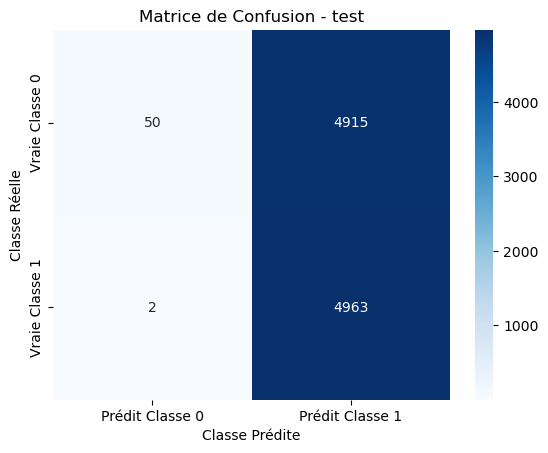

In [54]:
print("Seuil optimal test : ", optimal_threshold_test)

# Appliquer le Seuil Optimal
y_pred = (y_proba_test >= optimal_threshold_test).astype(int)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Transformation en DataFrame avec des labels
df_cm = pd.DataFrame(cm, index=["Vraie Classe 0", "Vraie Classe 1"], 
                         columns=["Pr√©dit Classe 0", "Pr√©dit Classe 1"])

sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Classe R√©elle")
plt.xlabel("Classe Pr√©dite")
plt.title("Matrice de Confusion - test")
plt.show()

### 3.4 - Simuler avec DecisionTree

2 hyperparam√®tres :

- max_depth (Profondeur maximale de l'arbre)
    - Description : D√©termine la profondeur maximale de l'arbre de d√©cision. Si ce param√®tre est d√©fini sur None, l'arbre continuera √† se diviser jusqu'√† ce qu'il atteigne les feuilles parfaites (c'est-√†-dire qu'il n'y ait plus d'am√©lioration possible dans les divisions).
    - Impact :
          - Profondeur trop petite : L'arbre peut √™tre sous-ajust√© (underfitting) et ne pourra pas capturer toute la complexit√© des donn√©es.
          - Profondeur trop grande : L'arbre peut √™tre sur-ajust√© (overfitting) et s'adapter trop bien aux bruits ou aux d√©tails sp√©cifiques des donn√©es d'entra√Ænement.
    - Utilit√© : C'est un hyperparam√®tre essentiel, car il contr√¥le directement la complexit√© du mod√®le et la capacit√© de l'arbre √† g√©n√©raliser.
  
- min_samples_split (Nombre minimum d'√©chantillons requis pour diviser un noeud)
    - Description : Ce param√®tre d√©finit le nombre minimum d'√©chantillons n√©cessaires pour effectuer une division dans un noeud. Si un noeud contient moins de ce nombre d'√©chantillons, il ne sera pas divis√©, et il deviendra une feuille.
    - Impact :
        - Valeur √©lev√©e : Cela emp√™che la division de noeuds lorsque les sous-groupes sont trop petits, ce qui peut limiter la capacit√© de l'arbre √† s'adapter aux petites variations des donn√©es. Cela peut √™tre utile pour r√©duire le surajustement.
        - Valeur faible : Si ce param√®tre est trop petit, l'arbre peut devenir trop sp√©cifique aux donn√©es d'entra√Ænement, ce qui entra√Æne un surajustement.
    - Utilit√© : Ce param√®tre aide √† contr√¥ler la taille de l'arbre et √† √©viter des divisions inutiles ou trop petites.


In [56]:
print("üìÇ Lancement du traitement DecisionTreeClassifier...")
start_time = timeit.default_timer()

# Initialisation du mod√®le
base_model = DecisionTreeClassifier(random_state=42)  # Utilisation d'un solver adapt√©

# Param√®tres √† tester dans GridSearchCV
param_grid = {
    'max_depth': [3, 5, 10, None],  # Profondeur maximale de l'arbre
    'min_samples_split': [2, 5, 10]  # Nombre minimum d'√©chantillons pour diviser un noeud
}

grid_search = GridSearchCV(
    base_model,
    param_grid=param_grid,
    scoring=metrics,
    refit="business_score",
    cv=5,
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(X_train, y_train)

# S√©lectionner le meilleur mod√®le de GridSearchCV
best_model = grid_search.best_estimator_

# Tracer la courbe ROC Curve
plt = print_ROC_curve_cv(best_model, X_train, y_train, X_test, y_test, cv=5)

# Sauvegarder le graphique dans un fichier
roc_curve_path = "roc_curve.png"
plt.savefig(roc_curve_path)
plt.close()

# Tracer la courbe PR Curve
plt = print_PR_curve(best_model, X_train, y_train, X_test, y_test)

# Sauvegarder le graphique dans un fichier
pr_curve_path = "pr_curve.png"
plt.savefig(pr_curve_path)
plt.close()

# Faire des pr√©dictions de probabilit√© sur l'ensemble de test
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]  # Probabilit√©s pour la classe positive

# Faire des pr√©dictions de probabilit√© sur l'ensemble de train
y_pred_proba_train = best_model.predict_proba(X_train)[:, 1]  # Probabilit√©s pour la classe positive

# Calculer l'AUC
auc_score_test = roc_auc_score(y_test, y_pred_proba_test)

# Calculer le seuil optimal test et train
optimal_threshold_train, min_business_score_train = find_optimal_threshold_business(y_train, y_pred_proba_train, calculate_errors_cost)
print("üìÇ", f"Seuil optimal train: {optimal_threshold_train:.4f}, Business Score minimal : {min_business_score_train:.4f}")

optimal_threshold_test, min_business_score_test = find_optimal_threshold_business(y_test, y_pred_proba_test, calculate_errors_cost)
print("üìÇ", f"Seuil optimal test: {optimal_threshold_test:.4f}, Business Score minimal : {min_business_score_test:.4f}")

save_model_mlflow(grid_search, "DecisionTreeClassifier_gridSearchCV", metrics, roc_curve_path, pr_curve_path, auc_score_test, optimal_threshold_test, min_business_score_test,
                 optimal_threshold_train, min_business_score_train)

# Supprimer le fichier temporaire
os.remove(roc_curve_path)
os.remove(pr_curve_path)

üìÇ Lancement du traitement DecisionTreeClassifier...
üìÇ Seuil optimal train: 0.1667, Business Score minimal : 19860.0000
üìÇ Seuil optimal test: 0.1667, Business Score minimal : 4965.0000
üìÇ Dur√©e depuis le d√©but :  117.783  - Fin entra√Ænement DecisionTreeClassifier_gridSearchCV ...
üìÇ Dur√©e depuis le d√©but :  117.783  - D√©but tracking MLFlow DecisionTreeClassifier_gridSearchCV ...


Registered model 'DecisionTreeClassifier_gridSearchCV' already exists. Creating a new version of this model...
2025/02/23 17:31:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DecisionTreeClassifier_gridSearchCV, version 3


best_business_score : -14848.2
mean_fit_time : 7.008
mean_business_score : -14848.2
mean_accuracy : 0.6512839879154079
mean_AUC : 0.7033163666308672
mean_f1_macro : 0.6506288971281606
mean_precision : 0.6524553732709388
mean_recall : 0.6512839879154078
üèÉ View run luminous-mole-890 at: http://127.0.0.1:5000/#/experiments/17/runs/32cdb72bfbb847a99b88857a895db1ec
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/17
Mod√®le enregistr√© en version 2.20.1
üìÇ Dur√©e depuis le d√©but :  123.805  - Fin tracking MLFlow DecisionTreeClassifier_gridSearchCV ...
‚úÖ Fin traitement DecisionTreeClassifier_gridSearchCV


Created version '3' of model 'DecisionTreeClassifier_gridSearchCV'.


In [57]:
print_result_CV_as_dataframe(grid_search, metrics) 

R√©sultats de la validation crois√©e :


params_  mean_score_AUC  \
0      {'max_depth': 5, 'min_samples_split': 10}        0.703316   
1       {'max_depth': 5, 'min_samples_split': 2}        0.703316   
2       {'max_depth': 5, 'min_samples_split': 5}        0.703316   
3      {'max_depth': 10, 'min_samples_split': 2}        0.669336   
4     {'max_depth': 10, 'min_samples_split': 10}        0.671319   
5      {'max_depth': 10, 'min_samples_split': 5}        0.669811   
6      {'max_depth': 3, 'min_samples_split': 10}        0.683224   
7       {'max_depth': 3, 'min_samples_split': 2}        0.683224   
8       {'max_depth': 3, 'min_samples_split': 5}        0.683224   
9    {'max_depth': None, 'min_samples_split': 2}        0.588369   
10   {'max_depth': None, 'min_samples_split': 5}        0.591858   
11  {'max_depth': None, 'min_samples_split': 10}        0.603676   

    mean_score_accuracy  mean_score_business_score  mean_score_f1_macro  \
0              0.651284                   -14848.2             0.650629   
1              0.651284                   -14848.2             0.650629   
2              0.651284                   -14848.2             0.650629   
3              0.638142                   -15235.2             0.637781   
4              0.637739                   -15236.6             0.637396   
5              0.638167                   -15262.0             0.637820   
6              0.647080                   -17761.6             0.645497   
7              0.647080                   -17761.6             0.645497   
8              0.647080                   -17761.6             0.645497   
9              0.588369                   -17979.6             0.588352   
10             0.585801                   -18295.2             0.585767   
11             0.585222                   -18440.2             0.585175   

    mean_score_precision  mean_score_recall  
0               0.652455           0.651284  
1               0.652455           0.651284  
2               0.652455           0.651284  
3               0.638687           0.638142  
4               0.638259           0.637739  
5               0.638695           0.638167  
6               0.649745           0.647080  
7               0.649745           0.647080  
8               0.649745           0.647080  
9               0.588383           0.588369  
10              0.585828           0.585801  
11              0.585259           0.585222

**Tra√ßons les histogrammes des probabilit√©s de pr√©diction**

Sur le ficher train :

<Axes: ylabel='Count'>

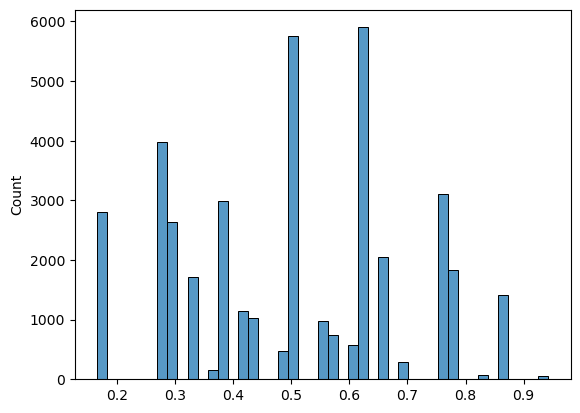

In [59]:
# R√©cup√©rer les probabilit√©s pr√©dites sur un jeu d'entra√Ænement
y_proba_train = best_model.predict_proba(X_train)[:,1]

# Afficher l'histogramme
sns.histplot(y_proba_train)

Sur le fichier test :

<Axes: ylabel='Count'>

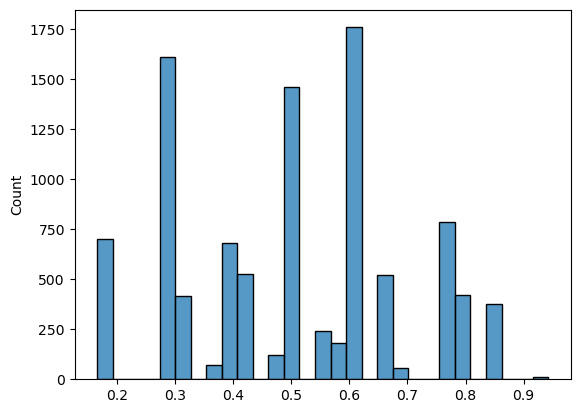

In [61]:
# R√©cup√©rer les probabilit√©s pr√©dites sur un jeu d'entra√Ænement
y_proba_test = best_model.predict_proba(X_test)[:,1]

# Afficher l'histogramme
sns.histplot(y_proba_test)

**Analyse du seuil optimal par rapport au score m√©tier**

Classe 0 : n√©gatif / Classe 1 : positif

- Un seuil bas ‚Üí Plus de refus (pr√™ts non accord√©s) ‚Üí R√©duit FN (mauvais client √† qui on accorde un pr√™t) mais augmente FP (bon client consid√©r√© comme mauvais).
- Un seuil haut ‚Üí Plus de pr√™ts accord√©s ‚Üí R√©duit FP mais augmente FN.
- Le seuil optimal est celui qui minimise ton score m√©tier  : 10 √ó FN + FP.

**Affichons la matrice de confusion avec le seuil optimal**

Sur le fichier d'entra√Ænement :

Seuil optimal train :  0.16666666666666666


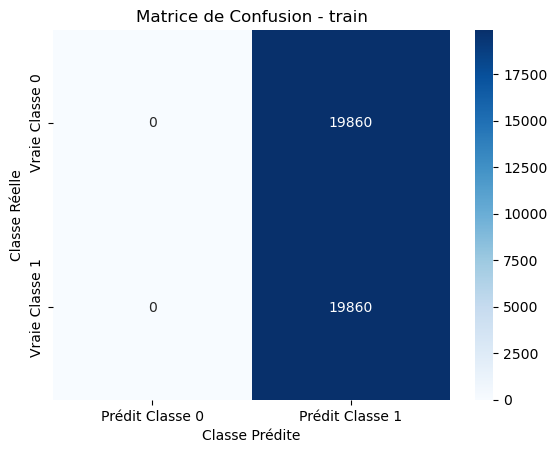

In [64]:
print("Seuil optimal train : ", optimal_threshold_train)

# Appliquer le Seuil Optimal
y_pred = (y_proba_train >= optimal_threshold_train).astype(int)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_train, y_pred)

# Transformation en DataFrame avec des labels
df_cm = pd.DataFrame(cm, index=["Vraie Classe 0", "Vraie Classe 1"], 
                         columns=["Pr√©dit Classe 0", "Pr√©dit Classe 1"])

sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Classe R√©elle")
plt.xlabel("Classe Pr√©dite")
plt.title("Matrice de Confusion - train")
plt.show()

Sur le fichier de test:

Seuil optimal test :  0.16666666666666666


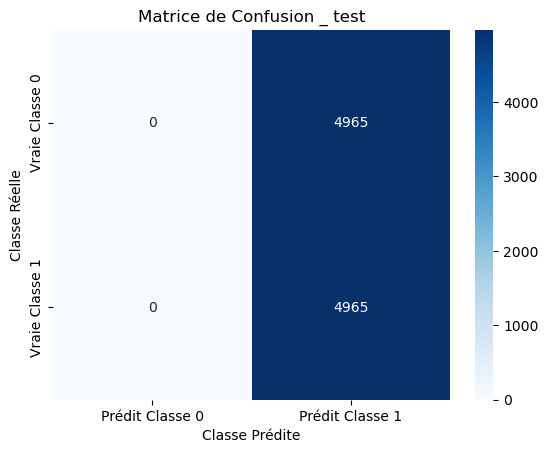

In [66]:
print("Seuil optimal test : ", optimal_threshold_test)

# Appliquer le Seuil Optimal
y_pred = (y_proba_test >= optimal_threshold_test).astype(int)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Transformation en DataFrame avec des labels
df_cm = pd.DataFrame(cm, index=["Vraie Classe 0", "Vraie Classe 1"], 
                         columns=["Pr√©dit Classe 0", "Pr√©dit Classe 1"])

sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Classe R√©elle")
plt.xlabel("Classe Pr√©dite")
plt.title("Matrice de Confusion _ test")
plt.show()

**Affichons la courbe ROC**

<module 'matplotlib.pyplot' from 'C:\\Users\\admin\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

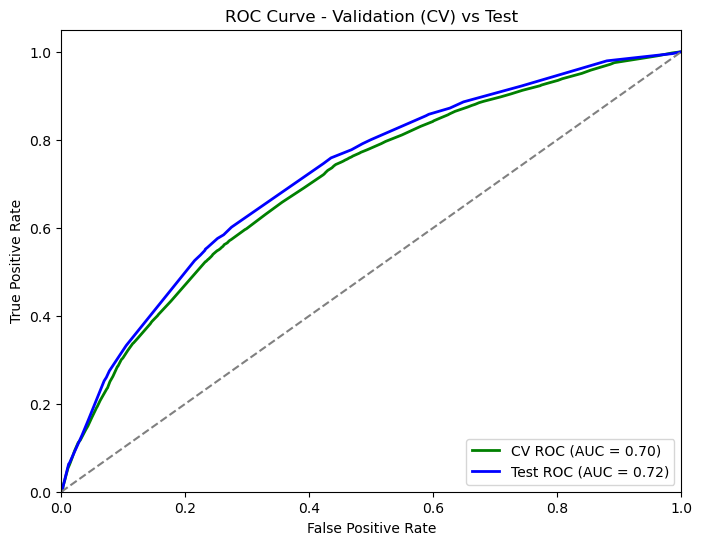

In [68]:
print_ROC_curve_cv(best_model, X_train, y_train, X_test, y_test, cv=5)

**Regardons la stabilit√© de l'AUC du meilleur mod√®le sur chaque fold**

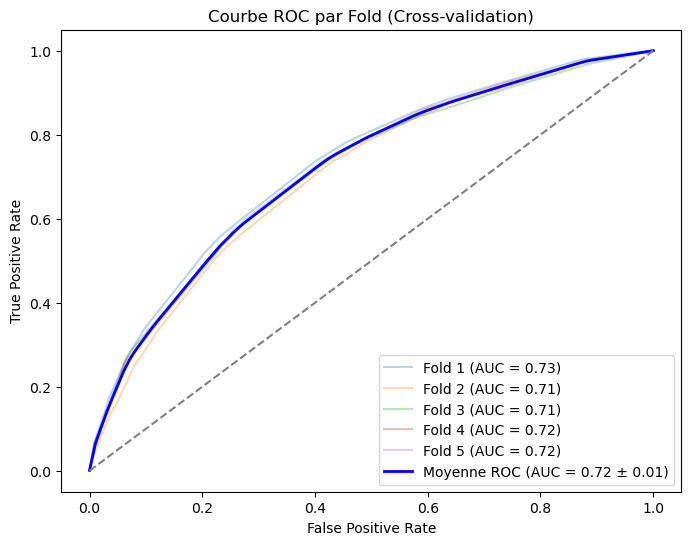

In [70]:
# Utilisation avec un GridSearchCV entra√Æn√©
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds stratifi√©s
plot_roc_folds(grid_search, X_train, y_train, cv)

### 3.5 - Simuler avec LightGBM

Les 3 hyperparam√®tres utilis√©s sont :
- n_estimators: Nombre d'arbres (plus il y en a, plus c'est pr√©cis mais long).
- learning_rate: Plus c'est bas, plus le mod√®le apprend lentement mais mieux.
- num_leaves: Nombre de feuilles par arbre (plus il y en a, plus le mod√®le est expressif).

In [92]:
print("üìÇ Lancement du traitement LightGBM...")
start_time = timeit.default_timer()

# Initialisation du mod√®le
base_model = LGBMClassifier(random_state=42)  # Utilisation d'un solver adapt√©

# Param√®tres √† tester dans GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 500],  # Nombre d'arbres
    'learning_rate': [0.01, 0.1, 0.2],  # Taux d'apprentissage
    'num_leaves': [7, 15, 31],  # Nombre de feuilles dans chaque arbre
}

grid_search = GridSearchCV(
    base_model,
    param_grid=param_grid,
    scoring=metrics,
    refit="business_score",
    cv=5,
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(X_train, y_train)

# S√©lectionner le meilleur mod√®le de GridSearchCV
best_model = grid_search.best_estimator_

# Tracer la courbe ROC Curve
plt = print_ROC_curve_cv(best_model, X_train, y_train, X_test, y_test, cv=5)

# Sauvegarder le graphique dans un fichier
roc_curve_path = "roc_curve.png"
plt.savefig(roc_curve_path)
plt.close()

# Tracer la courbe PR Curve
plt = print_PR_curve(best_model, X_train, y_train, X_test, y_test)

# Sauvegarder le graphique dans un fichier
pr_curve_path = "pr_curve.png"
plt.savefig(pr_curve_path)
plt.close()

# Faire des pr√©dictions de probabilit√© sur l'ensemble de test
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]  # Probabilit√©s pour la classe positive

# Faire des pr√©dictions de probabilit√© sur l'ensemble de train
y_pred_proba_train = best_model.predict_proba(X_train)[:, 1]  # Probabilit√©s pour la classe positive

# Calculer l'AUC
auc_score_test = roc_auc_score(y_test, y_pred_proba_test)

# Calculer le seuil optimal test et train
optimal_threshold_train, min_business_score_train = find_optimal_threshold_business(y_train, y_pred_proba_train, calculate_errors_cost)
print("üìÇ", f"Seuil optimal train: {optimal_threshold_train:.4f}, Business Score minimal : {min_business_score_train:.4f}")

optimal_threshold_test, min_business_score_test = find_optimal_threshold_business(y_test, y_pred_proba_test, calculate_errors_cost)
print("üìÇ", f"Seuil optimal test: {optimal_threshold_test:.4f}, Business Score minimal : {min_business_score_test:.4f}")

save_model_mlflow(grid_search, "LightGBM_gridSearchCV", metrics, roc_curve_path, pr_curve_path, auc_score_test, optimal_threshold_test, min_business_score_test,
                 optimal_threshold_train, min_business_score_train)

# Supprimer le fichier temporaire
os.remove(roc_curve_path)
os.remove(pr_curve_path)

üìÇ Lancement du traitement LightGBM...
[LightGBM] [Info] Number of positive: 19860, number of negative: 19860
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45810
[LightGBM] [Info] Number of data points in the train set: 39720, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15888, number of negative: 15888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45355
[LightGBM] [Info] Number of data points in the train set: 31776, number of used features: 357
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15888, number of negative: 15888
[Light

Registered model 'LightGBM_gridSearchCV' already exists. Creating a new version of this model...
2025/02/23 19:08:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM_gridSearchCV, version 3


best_business_score : -12963.6
mean_fit_time : 29.905
mean_business_score : -12963.6
mean_accuracy : 0.7038519637462236
mean_AUC : 0.7716133528861142
mean_f1_macro : 0.7038415614490351
mean_precision : 0.7038813275725005
mean_recall : 0.7038519637462235
üèÉ View run useful-hog-631 at: http://127.0.0.1:5000/#/experiments/17/runs/56e2001e2ec645ecbe465639ae5c0775
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/17
Mod√®le enregistr√© en version 2.20.1
üìÇ Dur√©e depuis le d√©but :  1738.04  - Fin tracking MLFlow LightGBM_gridSearchCV ...
‚úÖ Fin traitement LightGBM_gridSearchCV


Created version '3' of model 'LightGBM_gridSearchCV'.


In [93]:
print_result_CV_as_dataframe(grid_search, metrics)

R√©sultats de la validation crois√©e :


params_  mean_score_AUC  \
0   {'learning_rate': 0.1, 'n_estimators': 100, 'n...        0.771613   
1   {'learning_rate': 0.1, 'n_estimators': 500, 'n...        0.771906   
2   {'learning_rate': 0.1, 'n_estimators': 500, 'n...        0.774079   
3   {'learning_rate': 0.1, 'n_estimators': 500, 'n...        0.768841   
4   {'learning_rate': 0.1, 'n_estimators': 200, 'n...        0.771350   
5   {'learning_rate': 0.1, 'n_estimators': 200, 'n...        0.773161   
6   {'learning_rate': 0.1, 'n_estimators': 100, 'n...        0.771956   
7   {'learning_rate': 0.2, 'n_estimators': 100, 'n...        0.770421   
8   {'learning_rate': 0.01, 'n_estimators': 500, '...        0.769276   
9   {'learning_rate': 0.2, 'n_estimators': 200, 'n...        0.766066   
10  {'learning_rate': 0.1, 'n_estimators': 200, 'n...        0.772233   
11  {'learning_rate': 0.2, 'n_estimators': 100, 'n...        0.768367   
12  {'learning_rate': 0.2, 'n_estimators': 200, 'n...        0.770759   
13  {'learning_rate': 0.2, 'n_estimators': 500, 'n...        0.768538   
14  {'learning_rate': 0.2, 'n_estimators': 100, 'n...        0.765291   
15  {'learning_rate': 0.1, 'n_estimators': 100, 'n...        0.767445   
16  {'learning_rate': 0.01, 'n_estimators': 500, '...        0.765040   
17  {'learning_rate': 0.2, 'n_estimators': 500, 'n...        0.759906   
18  {'learning_rate': 0.2, 'n_estimators': 200, 'n...        0.760766   
19  {'learning_rate': 0.2, 'n_estimators': 500, 'n...        0.756927   
20  {'learning_rate': 0.01, 'n_estimators': 500, '...        0.757632   
21  {'learning_rate': 0.01, 'n_estimators': 200, '...        0.751570   
22  {'learning_rate': 0.01, 'n_estimators': 200, '...        0.745871   
23  {'learning_rate': 0.01, 'n_estimators': 100, '...        0.737605   
24  {'learning_rate': 0.01, 'n_estimators': 200, '...        0.736555   
25  {'learning_rate': 0.01, 'n_estimators': 100, '...        0.730057   
26  {'learning_rate': 0.01, 'n_estimators': 100, '...        0.718828   

    mean_score_accuracy  mean_score_business_score  mean_score_f1_macro  \
0              0.703852                   -12963.6             0.703842   
1              0.702996                   -12983.0             0.702993   
2              0.705463                   -12992.2             0.705456   
3              0.703348                   -12998.2             0.703345   
4              0.704003                   -13005.6             0.703996   
5              0.703625                   -13012.2             0.703617   
6              0.702115                   -13033.2             0.702111   
7              0.702669                   -13075.6             0.702664   
8              0.700881                   -13104.2             0.700878   
9              0.698212                   -13120.0             0.698209   
10             0.702669                   -13131.4             0.702661   
11             0.698640                   -13132.8             0.698638   
12             0.702014                   -13145.6             0.702005   
13             0.700629                   -13196.2             0.700623   
14             0.698162                   -13224.8             0.698158   
15             0.699824                   -13258.4             0.699816   
16             0.698414                   -13275.0             0.698408   
17             0.691994                   -13446.6             0.691989   
18             0.691944                   -13454.2             0.691941   
19             0.690911                   -13554.2             0.690908   
20             0.693328                   -13625.0             0.693309   
21             0.687462                   -13696.8             0.687455   
22             0.683635                   -13880.2             0.683626   
23             0.675604                   -14111.4             0.675596   
24             0.674824                   -14459.6             0.674801   
25             0.670544                   -14499.0 

**Tra√ßons les histogrammes des probabilit√©s de pr√©diction**

Sur le ficher train :

<Axes: ylabel='Count'>

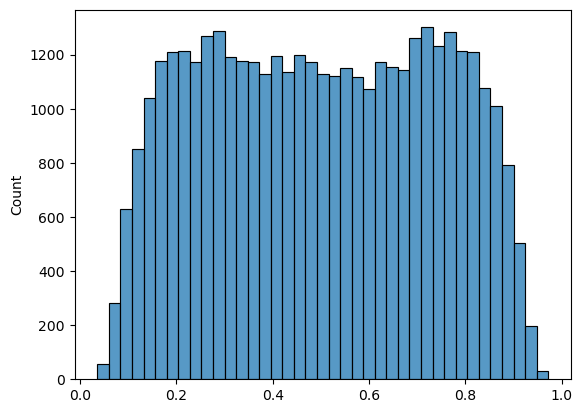

In [94]:
# R√©cup√©rer les probabilit√©s pr√©dites sur un jeu d'entra√Ænement
y_proba_train = best_model.predict_proba(X_train)[:,1]

# Afficher l'histogramme
sns.histplot(y_proba_train)

Sur le ficher test :

<Axes: ylabel='Count'>

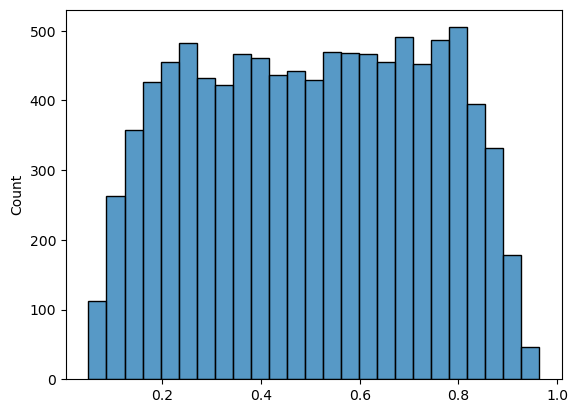

In [95]:
# R√©cup√©rer les probabilit√©s pr√©dites sur un jeu d'entra√Ænement
y_proba_test = best_model.predict_proba(X_test)[:,1]

# Afficher l'histogramme
sns.histplot(y_proba_test)

**Affichons la matrice de confusion avec le seuil optimal**

Sur le fichier d'entra√Ænement :

Seuil optimal train :  0.18144287319250132


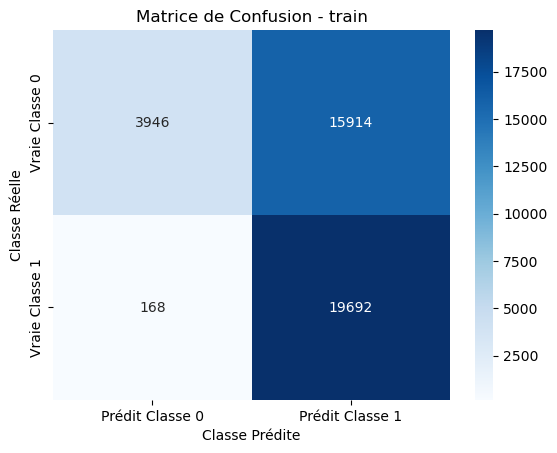

In [96]:
print("Seuil optimal train : ", optimal_threshold_train)

# Appliquer le Seuil Optimal
y_pred = (y_proba_train >= optimal_threshold_train).astype(int)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_train, y_pred)

# Transformation en DataFrame avec des labels
df_cm = pd.DataFrame(cm, index=["Vraie Classe 0", "Vraie Classe 1"], 
                         columns=["Pr√©dit Classe 0", "Pr√©dit Classe 1"])

sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Classe R√©elle")
plt.xlabel("Classe Pr√©dite")
plt.title("Matrice de Confusion - train")
plt.show()

Sur le fichier de test :

Seuil optimal test :  0.12950446505820803


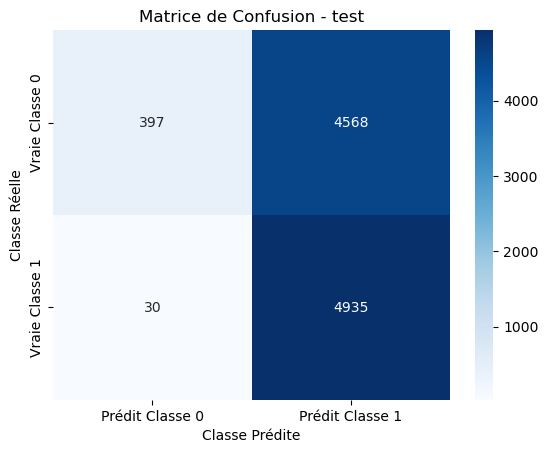

In [97]:
print("Seuil optimal test : ", optimal_threshold_test)

# Appliquer le Seuil Optimal
y_pred = (y_proba_test >= optimal_threshold_test).astype(int)

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Transformation en DataFrame avec des labels
df_cm = pd.DataFrame(cm, index=["Vraie Classe 0", "Vraie Classe 1"], 
                         columns=["Pr√©dit Classe 0", "Pr√©dit Classe 1"])

sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel("Classe R√©elle")
plt.xlabel("Classe Pr√©dite")
plt.title("Matrice de Confusion - test")
plt.show()

**Affichons la courbe ROC**

[LightGBM] [Info] Number of positive: 15888, number of negative: 15888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45355
[LightGBM] [Info] Number of data points in the train set: 31776, number of used features: 357
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15888, number of negative: 15888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45380
[LightGBM] [Info] Number of data points in the train set: 31776, number of used features: 357
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15888, number of negative: 15888
[LightGBM] [Info] Auto-choosing col-wise multi-

<module 'matplotlib.pyplot' from 'C:\\Users\\admin\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

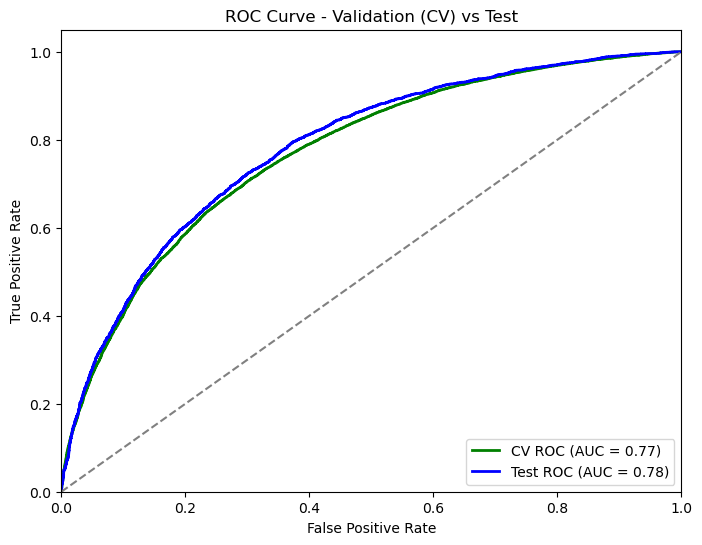

In [98]:
print_ROC_curve_cv(best_model, X_train, y_train, X_test, y_test, cv=5)

**Regardons la stabilit√© de l'AUC du meilleur mod√®le sur chaque fold**

[LightGBM] [Info] Number of positive: 15888, number of negative: 180916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.329047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46913
[LightGBM] [Info] Number of data points in the train set: 196804, number of used features: 371
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469
[LightGBM] [Info] Number of positive: 15888, number of negative: 180916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.469899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47008
[LightGBM] [Info] Number of data points in the train set: 196804, number of used features: 371
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469
[Lig

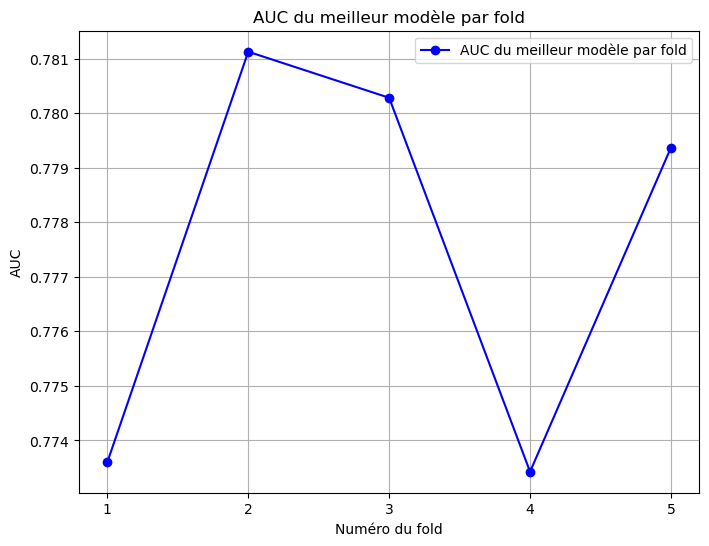

In [132]:
# Renommer les colonnes pour √©liminer les caract√®res sp√©ciaux
X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9_]', '_', regex=True)
X_test.columns = X_test.columns.str.replace('[^A-Za-z0-9_]', '_', regex=True)

# Validation crois√©e manuelle pour r√©cup√©rer l'AUC de chaque fold avec le meilleur mod√®le
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_per_fold = []

for train_idx, test_idx in kf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]

    # Entra√Æner le mod√®le sur chaque fold avec les meilleurs param√®tres
    best_model.fit(X_train_fold, y_train_fold)
    
    # Pr√©dictions sur le fold de test
    y_probs = best_model.predict_proba(X_test_fold)[:, 1]  # Probabilit√© pour la classe positive
    
    # Calculer l'AUC pour ce fold
    auc = roc_auc_score(y_test_fold, y_probs)
    auc_per_fold.append(auc)

# Tracer l'AUC pour chaque fold
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(auc_per_fold) + 1), auc_per_fold, marker='o', linestyle='-', color='b', label='AUC du meilleur mod√®le par fold')
plt.title('AUC du meilleur mod√®le par fold')
plt.xlabel('Num√©ro du fold')
plt.ylabel('AUC')
plt.xticks(np.arange(1, len(auc_per_fold) + 1))
plt.grid(True)
plt.legend()
plt.show()

### 3.6 - Conclusions

Le meilleur score m√©tier a √©t√© obtenu avec LightGBM (- 12 963), avec les hyperparam√®tres :
- learning_rate = 0.1
- n_estimators = 100
- num_leaves = 31

Il s'agit du score le plus proche de 0, donc le plus performant pour minimiser la fonction de co√ªt 10*FN + FP.
Son temps de traitement est beaucoup plus rapide que le LogisticRegression. Le plus rapide est DecisionTreeClassifier, mais le score m√©tier √©tait moins bon.

L'AUC moyen obtenu avec LightGBM lors de la validation crois√©e est 0.77. L'AUC est de 0.78 sur le fichier de test. Pr√©sence d'un tr√®s l√©ger surapprentissage.

**L'algorithme choisi est LightGBM avec les param√®tres suivants.**

Dans la suite nous affinerons les hyperparam√®tres pour optimiser le mod√®le.

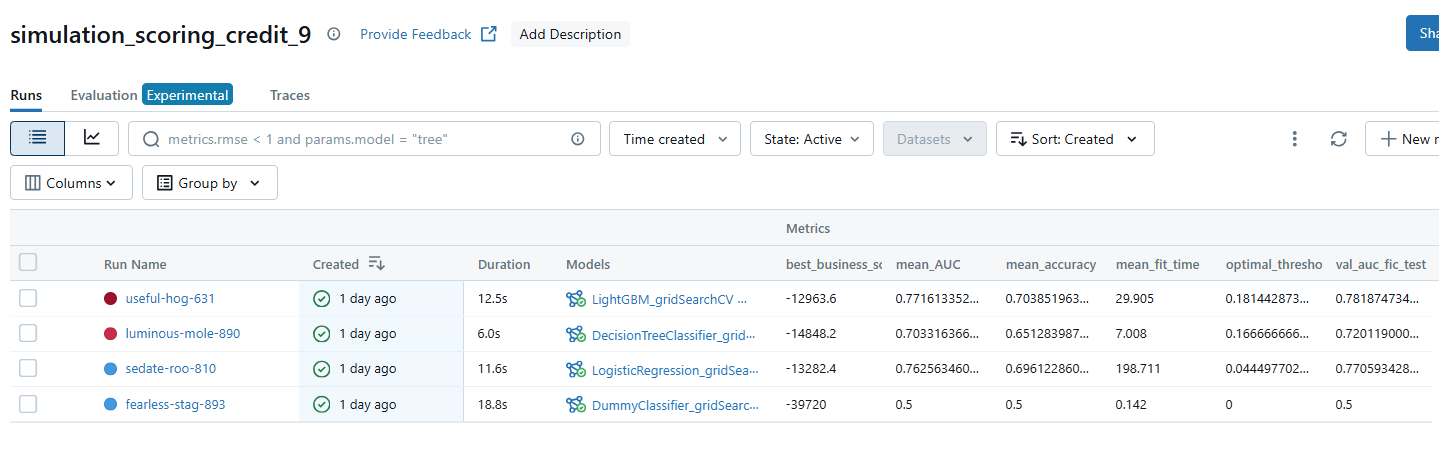

## 4 - Optimisation du mod√®le LightGBM

Le meilleur score m√©tier a √©t√© obtenu avec LightGBM (- 12 963), avec les hyperparam√®tres :

- learning_rate = 0.1
- n_estimators = 100
- num_leaves = 31

Les hyperparam√®tres en entr√©e du GridSearch √©tait :
- n_estimators: [100, 200, 500]
- learning_rate: [0.01, 0.1, 0.2]
- num_leaves: [7, 15, 31]

En 7√®me position, on trouvait un cas avec learning_rate = 0.2. Donc le meilleur learning_rate est peut-√™tre entre 0.05 et 0.15.
On peut √©galement essayer des valeurs de num_leaves entre 20 et 40.

In [26]:
print("üìÇ Lancement du traitement optimisation LightGBM...")
start_time = timeit.default_timer()

# Initialisation du mod√®le
base_model = LGBMClassifier(random_state=42)  # Utilisation d'un solver adapt√©

# Param√®tres √† tester dans GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 500],  # Nombre d'arbres
    'learning_rate': [0.05, 0.1, 0.15],  # Taux d'apprentissage
    'num_leaves': [20, 31, 40],  # Nombre de feuilles dans chaque arbre
}

grid_search = GridSearchCV(
    base_model,
    param_grid=param_grid,
    scoring=metrics,
    refit="business_score",
    cv=5,
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(X_train, y_train)

# S√©lectionner le meilleur mod√®le de GridSearchCV
best_model = grid_search.best_estimator_

# Tracer la courbe ROC Curve
plt = print_ROC_curve_cv(best_model, X_train, y_train, X_test, y_test, cv=5)

# Sauvegarder le graphique dans un fichier
roc_curve_path = "roc_curve.png"
plt.savefig(roc_curve_path)
plt.close()

# Tracer la courbe PR Curve
plt = print_PR_curve(best_model, X_train, y_train, X_test, y_test)

# Sauvegarder le graphique dans un fichier
pr_curve_path = "pr_curve.png"
plt.savefig(pr_curve_path)
plt.close()

# Faire des pr√©dictions de probabilit√© sur l'ensemble de test
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]  # Probabilit√©s pour la classe positive

# Faire des pr√©dictions de probabilit√© sur l'ensemble de train
y_pred_proba_train = best_model.predict_proba(X_train)[:, 1]  # Probabilit√©s pour la classe positive

# Calculer l'AUC
auc_score_test = roc_auc_score(y_test, y_pred_proba_test)

# Calculer le seuil optimal test et train
optimal_threshold_train, min_business_score_train = find_optimal_threshold_business(y_train, y_pred_proba_train, calculate_errors_cost)
print("üìÇ", f"Seuil optimal train: {optimal_threshold_train:.4f}, Business Score minimal : {min_business_score_train:.4f}")

optimal_threshold_test, min_business_score_test = find_optimal_threshold_business(y_test, y_pred_proba_test, calculate_errors_cost)
print("üìÇ", f"Seuil optimal test: {optimal_threshold_test:.4f}, Business Score minimal : {min_business_score_test:.4f}")

save_model_mlflow(grid_search, "Optimisation_LightGBM_gridSearchCV", metrics, roc_curve_path, pr_curve_path, auc_score_test, optimal_threshold_test, min_business_score_test,
                 optimal_threshold_train, min_business_score_train)

# Supprimer le fichier temporaire
os.remove(roc_curve_path)
os.remove(pr_curve_path)

üìÇ Lancement du traitement optimisation LightGBM...
[LightGBM] [Info] Number of positive: 19860, number of negative: 19860
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45871
[LightGBM] [Info] Number of data points in the train set: 39720, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15888, number of negative: 15888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45398
[LightGBM] [Info] Number of data points in the train set: 31776, number of used features: 355
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15888, number of negative:

Successfully registered model 'Optimisation_LightGBM_gridSearchCV'.
2025/02/25 09:29:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Optimisation_LightGBM_gridSearchCV, version 1


best_business_score : -13063.4
mean_fit_time : 71.873
mean_business_score : -13063.4
mean_accuracy : 0.7046576032225579
mean_AUC : 0.7746752950411187
mean_f1_macro : 0.7046473401309437
mean_precision : 0.7046857961086815
mean_recall : 0.7046576032225579
üèÉ View run suave-bee-811 at: http://127.0.0.1:5000/#/experiments/17/runs/9facdd4e621b4c06b7959308fcb533fa
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/17
Mod√®le enregistr√© en version 2.20.1
üìÇ Dur√©e depuis le d√©but :  2001.859  - Fin tracking MLFlow Optimisation_LightGBM_gridSearchCV ...
‚úÖ Fin traitement Optimisation_LightGBM_gridSearchCV


Created version '1' of model 'Optimisation_LightGBM_gridSearchCV'.


In [41]:
print_result_CV_as_dataframe(grid_search, metrics)

R√©sultats de la validation crois√©e :


params_  mean_score_AUC  \
0   {'learning_rate': 0.05, 'n_estimators': 500, '...        0.774675   
1   {'learning_rate': 0.1, 'n_estimators': 100, 'n...        0.772463   
2   {'learning_rate': 0.1, 'n_estimators': 200, 'n...        0.771632   
3   {'learning_rate': 0.05, 'n_estimators': 200, '...        0.773600   
4   {'learning_rate': 0.05, 'n_estimators': 200, '...        0.773935   
5   {'learning_rate': 0.1, 'n_estimators': 200, 'n...        0.771045   
6   {'learning_rate': 0.05, 'n_estimators': 200, '...        0.774035   
7   {'learning_rate': 0.1, 'n_estimators': 100, 'n...        0.772251   
8   {'learning_rate': 0.1, 'n_estimators': 200, 'n...        0.773000   
9   {'learning_rate': 0.15, 'n_estimators': 100, '...        0.771094   
10  {'learning_rate': 0.1, 'n_estimators': 100, 'n...        0.772748   
11  {'learning_rate': 0.05, 'n_estimators': 500, '...        0.773354   
12  {'learning_rate': 0.05, 'n_estimators': 500, '...        0.772978   
13  {'learning_rate': 0.15, 'n_estimators': 200, '...        0.769257   
14  {'learning_rate': 0.1, 'n_estimators': 500, 'n...        0.767594   
15  {'learning_rate': 0.1, 'n_estimators': 500, 'n...        0.768792   
16  {'learning_rate': 0.05, 'n_estimators': 100, '...        0.769741   
17  {'learning_rate': 0.05, 'n_estimators': 100, '...        0.768927   
18  {'learning_rate': 0.15, 'n_estimators': 100, '...        0.767526   
19  {'learning_rate': 0.1, 'n_estimators': 500, 'n...        0.770276   
20  {'learning_rate': 0.15, 'n_estimators': 100, '...        0.769043   
21  {'learning_rate': 0.05, 'n_estimators': 100, '...        0.767295   
22  {'learning_rate': 0.15, 'n_estimators': 500, '...        0.764106   
23  {'learning_rate': 0.15, 'n_estimators': 200, '...        0.767147   
24  {'learning_rate': 0.15, 'n_estimators': 500, '...        0.762551   
25  {'learning_rate': 0.15, 'n_estimators': 200, '...        0.763173   
26  {'learning_rate': 0.15, 'n_estimators': 500, '...        0.760901   

    mean_score_accuracy  mean_score_business_score  mean_score_f1_macro  \
0              0.704658                   -13063.4             0.704647   
1              0.702845                   -13092.2             0.702839   
2              0.702895                   -13095.4             0.702887   
3              0.703474                   -13098.0             0.703466   
4              0.703701                   -13103.4             0.703691   
5              0.701737                   -13106.4             0.701730   
6              0.703751                   -13106.6             0.703740   
7              0.701687                   -13112.2             0.701677   
8              0.703399                   -13147.2             0.703385   
9              0.701334                   -13154.6             0.701327   
10             0.702795                   -13159.2             0.702776   
11             0.702341                   -13197.0             0.702330   
12             0.701360                   -13204.8             0.701344   
13             0.699648                   -13236.4             0.699640   
14             0.699068                   -13237.4             0.699057   
15             0.699144                   -13258.4             0.699132   
16             0.700629                   -13286.2             0.700616   
17             0.700025                   -13291.0             0.700015   
18             0.699446                   -13293.8             0.699435   
19             0.699748                   -13295.0             0.699739   
20             0.699849                   -13301.4             0.699833   
21             0.699194                   -13373.2             0.699178   
22             0.696878                   -13377.2             0.696865   
23             0.698187                   -13381.2             0.698174   
24             0.697382                   -13384.0             0.697368   
25             0.695393                   -13455.6 

On constate que le temps moyen de traitement est plus long avec learning_rate de 0.05 pour un score m√©tier mmoyen bon au final. Je reviens √† une valeur de 0.1.

In [44]:
print("üìÇ Lancement du traitement optimisation LightGBM...")
start_time = timeit.default_timer()

# Initialisation du mod√®le
base_model = LGBMClassifier(random_state=42)  # Utilisation d'un solver adapt√©

# Param√®tres √† tester dans GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 500, 1000],  # Nombre d'arbres
    'learning_rate': [0.1],  # Taux d'apprentissage
    'num_leaves': [31, 64],  # Nombre de feuilles dans chaque arbre
}

grid_search = GridSearchCV(
    base_model,
    param_grid=param_grid,
    scoring=metrics,
    refit="business_score",
    cv=5,
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(X_train, y_train)

# S√©lectionner le meilleur mod√®le de GridSearchCV
best_model = grid_search.best_estimator_

# Tracer la courbe ROC Curve
plt = print_ROC_curve_cv(best_model, X_train, y_train, X_test, y_test, cv=5)

# Sauvegarder le graphique dans un fichier
roc_curve_path = "roc_curve.png"
plt.savefig(roc_curve_path)
plt.close()

# Tracer la courbe PR Curve
plt = print_PR_curve(best_model, X_train, y_train, X_test, y_test)

# Sauvegarder le graphique dans un fichier
pr_curve_path = "pr_curve.png"
plt.savefig(pr_curve_path)
plt.close()

# Faire des pr√©dictions de probabilit√© sur l'ensemble de test
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]  # Probabilit√©s pour la classe positive

# Faire des pr√©dictions de probabilit√© sur l'ensemble de train
y_pred_proba_train = best_model.predict_proba(X_train)[:, 1]  # Probabilit√©s pour la classe positive

# Calculer l'AUC
auc_score_test = roc_auc_score(y_test, y_pred_proba_test)

# Calculer le seuil optimal test et train
optimal_threshold_train, min_business_score_train = find_optimal_threshold_business(y_train, y_pred_proba_train, calculate_errors_cost)
print("üìÇ", f"Seuil optimal train: {optimal_threshold_train:.4f}, Business Score minimal : {min_business_score_train:.4f}")

optimal_threshold_test, min_business_score_test = find_optimal_threshold_business(y_test, y_pred_proba_test, calculate_errors_cost)
print("üìÇ", f"Seuil optimal test: {optimal_threshold_test:.4f}, Business Score minimal : {min_business_score_test:.4f}")

save_model_mlflow(grid_search, "Optimisation_LightGBM_gridSearchCV", metrics, roc_curve_path, pr_curve_path, auc_score_test, optimal_threshold_test, min_business_score_test,
                 optimal_threshold_train, min_business_score_train)

# Supprimer le fichier temporaire
os.remove(roc_curve_path)
os.remove(pr_curve_path)

üìÇ Lancement du traitement optimisation LightGBM...
[LightGBM] [Info] Number of positive: 19860, number of negative: 19860
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45871
[LightGBM] [Info] Number of data points in the train set: 39720, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15888, number of negative: 15888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45398
[LightGBM] [Info] Number of data points in the train set: 31776, number of used features: 355
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15888, number of negative:

Registered model 'Optimisation_LightGBM_gridSearchCV' already exists. Creating a new version of this model...
2025/02/25 10:32:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Optimisation_LightGBM_gridSearchCV, version 2


best_business_score : -13092.2
mean_fit_time : 38.834
mean_business_score : -13092.2
mean_accuracy : 0.7028449144008055
mean_AUC : 0.7724627401883678
mean_f1_macro : 0.7028393119172505
mean_precision : 0.7028597585315832
mean_recall : 0.7028449144008055
üèÉ View run debonair-ox-392 at: http://127.0.0.1:5000/#/experiments/17/runs/6514d5bf72b74a73a28d72ff3206bc81
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/17
Mod√®le enregistr√© en version 2.20.1
üìÇ Dur√©e depuis le d√©but :  3020.653  - Fin tracking MLFlow Optimisation_LightGBM_gridSearchCV ...
‚úÖ Fin traitement Optimisation_LightGBM_gridSearchCV


Created version '2' of model 'Optimisation_LightGBM_gridSearchCV'.


In [46]:
print_result_CV_as_dataframe(grid_search, metrics)

R√©sultats de la validation crois√©e :


params_  mean_score_AUC  \
0  {'learning_rate': 0.1, 'n_estimators': 100, 'n...        0.772463   
1  {'learning_rate': 0.1, 'n_estimators': 200, 'n...        0.771632   
2  {'learning_rate': 0.1, 'n_estimators': 100, 'n...        0.770312   
3  {'learning_rate': 0.1, 'n_estimators': 200, 'n...        0.769089   
4  {'learning_rate': 0.1, 'n_estimators': 500, 'n...        0.768792   
5  {'learning_rate': 0.1, 'n_estimators': 1000, '...        0.766563   
6  {'learning_rate': 0.1, 'n_estimators': 500, 'n...        0.767512   
7  {'learning_rate': 0.1, 'n_estimators': 1000, '...        0.767928   

   mean_score_accuracy  mean_score_business_score  mean_score_f1_macro  \
0             0.702845                   -13092.2             0.702839   
1             0.702895                   -13095.4             0.702887   
2             0.700302                   -13198.8             0.700297   
3             0.699824                   -13236.8             0.699818   
4             0.699144                   -13258.4             0.699132   
5             0.696702                   -13313.8             0.696699   
6             0.697029                   -13359.8             0.697020   
7             0.696652                   -13469.0             0.696635   

   mean_score_precision  mean_score_recall  
0              0.702860           0.702845  
1              0.702918           0.702895  
2              0.700317           0.700302  
3              0.699839           0.699824  
4              0.699176           0.699144  
5              0.696710           0.696702  
6              0.697052           0.697029  
7              0.696693           0.696652

In [48]:
print("üìÇ Lancement du traitement optimisation LightGBM...")
start_time = timeit.default_timer()

# Initialisation du mod√®le
base_model = LGBMClassifier(random_state=42)  # Utilisation d'un solver adapt√©

# Param√®tres √† tester dans GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],  # Nombre d'arbres
    'learning_rate': [0.1],  # Taux d'apprentissage
    'num_leaves': [31],  # Nombre de feuilles dans chaque arbre
}

grid_search = GridSearchCV(
    base_model,
    param_grid=param_grid,
    scoring=metrics,
    refit="business_score",
    cv=5,
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(X_train, y_train)

# S√©lectionner le meilleur mod√®le de GridSearchCV
best_model = grid_search.best_estimator_

# Tracer la courbe ROC Curve
plt = print_ROC_curve_cv(best_model, X_train, y_train, X_test, y_test, cv=5)

# Sauvegarder le graphique dans un fichier
roc_curve_path = "roc_curve.png"
plt.savefig(roc_curve_path)
plt.close()

# Tracer la courbe PR Curve
plt = print_PR_curve(best_model, X_train, y_train, X_test, y_test)

# Sauvegarder le graphique dans un fichier
pr_curve_path = "pr_curve.png"
plt.savefig(pr_curve_path)
plt.close()

# Faire des pr√©dictions de probabilit√© sur l'ensemble de test
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]  # Probabilit√©s pour la classe positive

# Faire des pr√©dictions de probabilit√© sur l'ensemble de train
y_pred_proba_train = best_model.predict_proba(X_train)[:, 1]  # Probabilit√©s pour la classe positive

# Calculer l'AUC
auc_score_test = roc_auc_score(y_test, y_pred_proba_test)

# Calculer le seuil optimal test et train
optimal_threshold_train, min_business_score_train = find_optimal_threshold_business(y_train, y_pred_proba_train, calculate_errors_cost)
print("üìÇ", f"Seuil optimal train: {optimal_threshold_train:.4f}, Business Score minimal : {min_business_score_train:.4f}")

optimal_threshold_test, min_business_score_test = find_optimal_threshold_business(y_test, y_pred_proba_test, calculate_errors_cost)
print("üìÇ", f"Seuil optimal test: {optimal_threshold_test:.4f}, Business Score minimal : {min_business_score_test:.4f}")

save_model_mlflow(grid_search, "Optimisation_LightGBM_gridSearchCV", metrics, roc_curve_path, pr_curve_path, auc_score_test, optimal_threshold_test, min_business_score_test,
                 optimal_threshold_train, min_business_score_train)

# Supprimer le fichier temporaire
os.remove(roc_curve_path)
os.remove(pr_curve_path)

üìÇ Lancement du traitement optimisation LightGBM...
[LightGBM] [Info] Number of positive: 19860, number of negative: 19860
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45871
[LightGBM] [Info] Number of data points in the train set: 39720, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15888, number of negative: 15888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45398
[LightGBM] [Info] Number of data points in the train set: 31776, number of used features: 355
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15888, number of negative:

Registered model 'Optimisation_LightGBM_gridSearchCV' already exists. Creating a new version of this model...
2025/02/25 11:42:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Optimisation_LightGBM_gridSearchCV, version 3
Created version '3' of model 'Optimisation_LightGBM_gridSearchCV'.


best_business_score : -13092.2
mean_fit_time : 40.446
mean_business_score : -13092.2
mean_accuracy : 0.7028449144008055
mean_AUC : 0.7724627401883678
mean_f1_macro : 0.7028393119172505
mean_precision : 0.7028597585315832
mean_recall : 0.7028449144008055
üèÉ View run mysterious-panda-892 at: http://127.0.0.1:5000/#/experiments/17/runs/9db5b467e7f6407a91d0861717457525
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/17
Mod√®le enregistr√© en version 2.20.1
üìÇ Dur√©e depuis le d√©but :  2336.485  - Fin tracking MLFlow Optimisation_LightGBM_gridSearchCV ...
‚úÖ Fin traitement Optimisation_LightGBM_gridSearchCV


In [50]:
print_result_CV_as_dataframe(grid_search, metrics)

R√©sultats de la validation crois√©e :


params_  mean_score_AUC  \
0  {'learning_rate': 0.1, 'n_estimators': 100, 'n...        0.772463   
1  {'learning_rate': 0.1, 'n_estimators': 150, 'n...        0.772128   
2  {'learning_rate': 0.1, 'n_estimators': 50, 'nu...        0.768307   

   mean_score_accuracy  mean_score_business_score  mean_score_f1_macro  \
0             0.702845                   -13092.2             0.702839   
1             0.703600                   -13106.0             0.703589   
2             0.699522                   -13278.8             0.699511   

   mean_score_precision  mean_score_recall  
0              0.702860           0.702845  
1              0.703630           0.703600  
2              0.699549           0.699522

In [52]:
print("üìÇ Lancement du traitement optimisation LightGBM...")
start_time = timeit.default_timer()

# Initialisation du mod√®le
base_model = LGBMClassifier(random_state=42)  # Utilisation d'un solver adapt√©

# Param√®tres √† tester dans GridSearchCV
param_grid = {
    'n_estimators': [100],  # Nombre d'arbres
    'learning_rate': [0.1],  # Taux d'apprentissage
    'num_leaves': [31],  # Nombre de feuilles dans chaque arbre
}

grid_search = GridSearchCV(
    base_model,
    param_grid=param_grid,
    scoring=metrics,
    refit="business_score",
    cv=5,
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(X_train, y_train)

# S√©lectionner le meilleur mod√®le de GridSearchCV
best_model = grid_search.best_estimator_

# Tracer la courbe ROC Curve
plt = print_ROC_curve_cv(best_model, X_train, y_train, X_test, y_test, cv=5)

# Sauvegarder le graphique dans un fichier
roc_curve_path = "roc_curve.png"
plt.savefig(roc_curve_path)
plt.close()

# Tracer la courbe PR Curve
plt = print_PR_curve(best_model, X_train, y_train, X_test, y_test)

# Sauvegarder le graphique dans un fichier
pr_curve_path = "pr_curve.png"
plt.savefig(pr_curve_path)
plt.close()

# Faire des pr√©dictions de probabilit√© sur l'ensemble de test
y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]  # Probabilit√©s pour la classe positive

# Faire des pr√©dictions de probabilit√© sur l'ensemble de train
y_pred_proba_train = best_model.predict_proba(X_train)[:, 1]  # Probabilit√©s pour la classe positive

# Calculer l'AUC
auc_score_test = roc_auc_score(y_test, y_pred_proba_test)

# Calculer le seuil optimal test et train
optimal_threshold_train, min_business_score_train = find_optimal_threshold_business(y_train, y_pred_proba_train, calculate_errors_cost)
print("üìÇ", f"Seuil optimal train: {optimal_threshold_train:.4f}, Business Score minimal : {min_business_score_train:.4f}")

optimal_threshold_test, min_business_score_test = find_optimal_threshold_business(y_test, y_pred_proba_test, calculate_errors_cost)
print("üìÇ", f"Seuil optimal test: {optimal_threshold_test:.4f}, Business Score minimal : {min_business_score_test:.4f}")

save_model_mlflow(grid_search, "Optimisation_LightGBM_gridSearchCV", metrics, roc_curve_path, pr_curve_path, auc_score_test, optimal_threshold_test, min_business_score_test,
                 optimal_threshold_train, min_business_score_train)

# Supprimer le fichier temporaire
os.remove(roc_curve_path)
os.remove(pr_curve_path)

üìÇ Lancement du traitement optimisation LightGBM...
[LightGBM] [Info] Number of positive: 19860, number of negative: 19860
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.209943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45871
[LightGBM] [Info] Number of data points in the train set: 39720, number of used features: 359
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15888, number of negative: 15888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45398
[LightGBM] [Info] Number of data points in the train set: 31776, number of used features: 355
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15888, number of negative:

Registered model 'Optimisation_LightGBM_gridSearchCV' already exists. Creating a new version of this model...
2025/02/25 12:26:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Optimisation_LightGBM_gridSearchCV, version 4
Created version '4' of model 'Optimisation_LightGBM_gridSearchCV'.


best_business_score : -13092.2
mean_fit_time : 24.324
mean_business_score : -13092.2
mean_accuracy : 0.7028449144008055
mean_AUC : 0.7724627401883678
mean_f1_macro : 0.7028393119172505
mean_precision : 0.7028597585315832
mean_recall : 0.7028449144008055
üèÉ View run painted-pig-560 at: http://127.0.0.1:5000/#/experiments/17/runs/cd6899dd228a417d883723cceb3f642a
üß™ View experiment at: http://127.0.0.1:5000/#/experiments/17
Mod√®le enregistr√© en version 2.20.1
üìÇ Dur√©e depuis le d√©but :  2302.734  - Fin tracking MLFlow Optimisation_LightGBM_gridSearchCV ...
‚úÖ Fin traitement Optimisation_LightGBM_gridSearchCV


In [66]:
print_result_CV_as_dataframe(grid_search, metrics)

R√©sultats de la validation crois√©e :


params_  mean_score_AUC  \
0  {'learning_rate': 0.1, 'n_estimators': 100, 'n...        0.772463   

   mean_score_accuracy  mean_score_business_score  mean_score_f1_macro  \
0             0.702845                   -13092.2             0.702839   

   mean_score_precision  mean_score_recall  
0               0.70286           0.702845

## 5 - Analyser la feature importance globale et locale du meilleur mod√®le

### 5.1 - Cr√©ation d‚Äôun objet explicatif (Explainer)

Nous devrons cr√©er un objet explicatif afin de tracer divers graphiques expliquant une pr√©diction particuli√®re.

Les pr√©dictions du mod√®le LightGBM ne sont pas directement des probabilit√©s, mais plut√¥t des log-odds (logits), qui peuvent √™tre positifs ou n√©gatifs. LightGBM, par d√©faut, pr√©dit des valeurs en log-odds avant l'application de la fonction sigmo√Øde pour obtenir une probabilit√©.

- Si log-odds > 0 ‚Üí la classe 1 est plus probable que la classe 0.
- Si log-odds < 0 ‚Üí la classe 0 est plus probable que la classe 1.
- Si log-odds = 0 ‚Üí les deux classes ont 50% de probabilit√©.

In [83]:
explainer = shap.Explainer(best_model, X_train)  # Cr√©er l'explainer SHAP

### 5.2 - Feature importance globale

 99%|===================| 9869/9930 [01:41<00:00]        

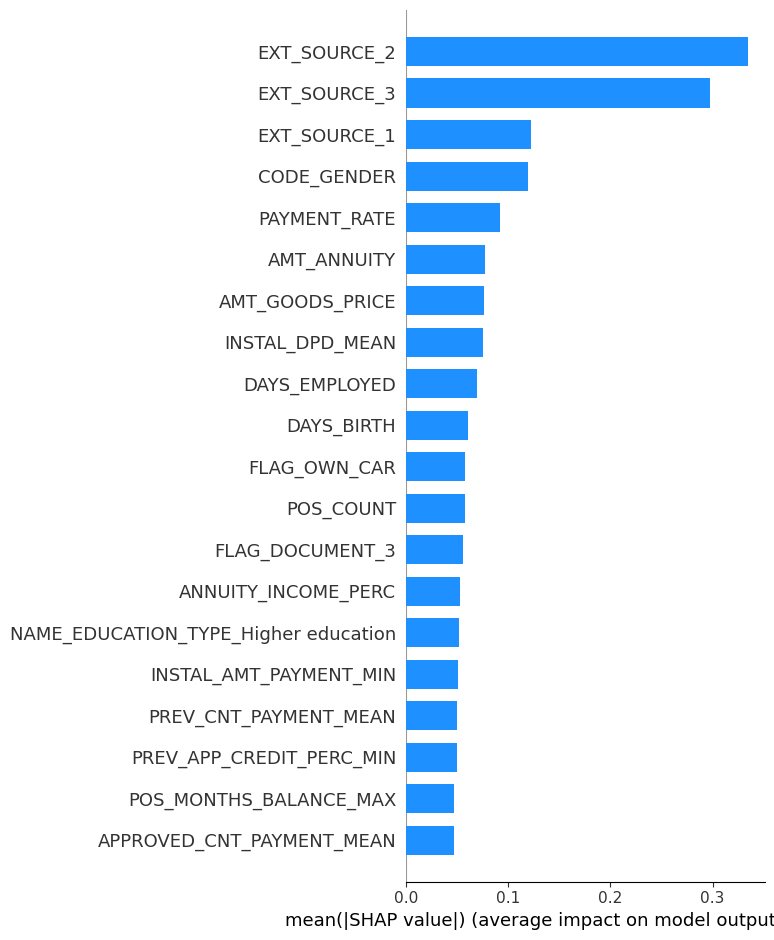

In [85]:
shap.summary_plot(explainer.shap_values(X_test, check_additivity=False),
                  feature_names=X.columns,
                  plot_type="bar",
                  color="dodgerblue"
                  )

### 5.3 - Feature importance locale

**1er √©chantillon**

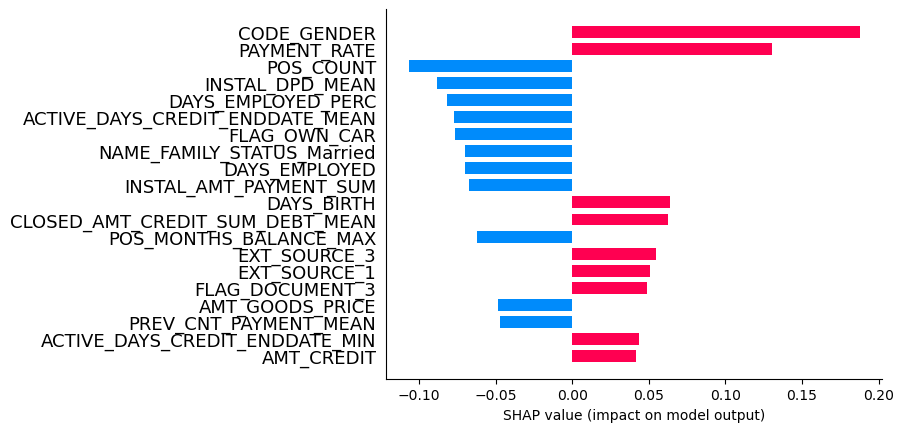

In [137]:
shap.bar_plot(explainer.shap_values(X_test[0]),
              feature_names=X.columns,
              max_display=20)

In [114]:
shap.force_plot(explainer.expected_value,
                explainer.shap_values(X_test[0]),
                feature_names=X.columns,
                out_names="pr√©diction")

In [91]:
# Associer noms et valeurs
for col, val in zip(X.columns, X_test[0]):
    print(f"{col}: {val}")

SK_ID_CURR: 1.1318700079403567
CNT_CHILDREN: -0.5894217207263497
AMT_INCOME_TOTAL: -0.018928997117881256
AMT_CREDIT: 0.012507108810516263
AMT_ANNUITY: 0.10644971927699
AMT_GOODS_PRICE: -0.12393183274436381
REGION_POPULATION_RELATIVE: -0.15851381330933634
DAYS_BIRTH: 0.3058822964573959
DAYS_EMPLOYED: -0.8160281405069515
DAYS_REGISTRATION: 0.03076522254585561
DAYS_ID_PUBLISH: -1.1646748765134527
FLAG_MOBIL: 0.0
FLAG_EMP_PHONE: 0.4278366793191026
FLAG_WORK_PHONE: -0.5254087773387821
FLAG_CONT_MOBILE: 0.04332005210594774
FLAG_PHONE: -0.5988623920597015
FLAG_EMAIL: -0.2442841261338073
CNT_FAM_MEMBERS: -0.17642728791916854
REGION_RATING_CLIENT: 1.7711005498954453
REGION_RATING_CLIENT_W_CITY: 1.8295815481137208
HOUR_APPR_PROCESS_START: 0.32483087104161257
REG_REGION_NOT_LIVE_REGION: -0.1289433886532155
REG_REGION_NOT_WORK_REGION: -0.2394322970377488
LIVE_REGION_NOT_WORK_REGION: -0.21166304770797895
REG_CITY_NOT_LIVE_CITY: -0.3266159213159415
REG_CITY_NOT_WORK_CITY: -0.6021842759838771
LIVE_CI

**2√®me √©chantillon**

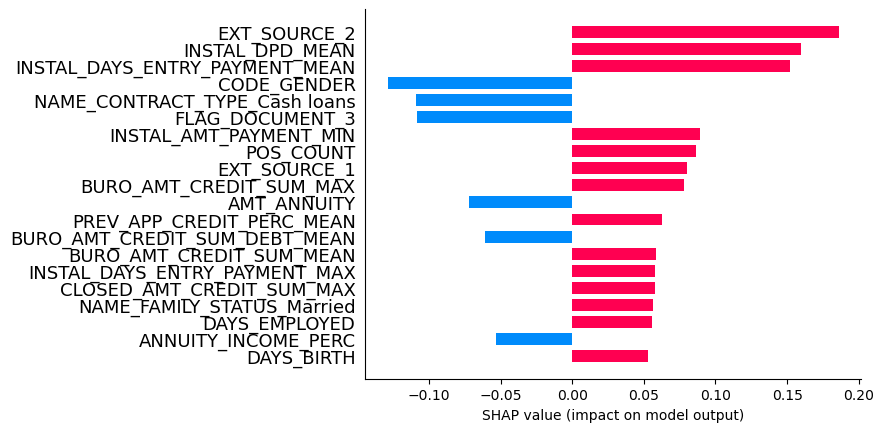

In [131]:
shap.bar_plot(explainer.shap_values(X_test[4]),
              feature_names=X.columns,
              max_display=20)

In [133]:
shap.force_plot(explainer.expected_value,
                explainer.shap_values(X_test[4]),
                feature_names=X.columns,
                out_names="pr√©diction")

In [135]:
# Associer noms et valeurs
for col, val in zip(X.columns, X_test[4]):
    print(f"{col}: {val}")

SK_ID_CURR: 1.0670527983878042
CNT_CHILDREN: -0.5894217207263497
AMT_INCOME_TOTAL: -0.061153686385259566
AMT_CREDIT: -0.8174076822819716
AMT_ANNUITY: -0.9813107676437793
AMT_GOODS_PRICE: -0.7100738171741511
REGION_POPULATION_RELATIVE: -0.09944360984249102
DAYS_BIRTH: 0.022708350888798176
DAYS_EMPLOYED: 0.6432921349693471
DAYS_REGISTRATION: 0.09933655717322168
DAYS_ID_PUBLISH: 0.5314779966547232
FLAG_MOBIL: 0.0
FLAG_EMP_PHONE: 0.4278366793191026
FLAG_WORK_PHONE: -0.5254087773387821
FLAG_CONT_MOBILE: 0.04332005210594774
FLAG_PHONE: -0.5988623920597015
FLAG_EMAIL: -0.2442841261338073
CNT_FAM_MEMBERS: -1.2516224327806793
REGION_RATING_CLIENT: -0.19055520003894338
REGION_RATING_CLIENT_W_CITY: -0.1542298487818076
HOUR_APPR_PROCESS_START: -0.8963979219326279
REG_REGION_NOT_LIVE_REGION: -0.1289433886532155
REG_REGION_NOT_WORK_REGION: -0.2394322970377488
LIVE_REGION_NOT_WORK_REGION: -0.21166304770797895
REG_CITY_NOT_LIVE_CITY: -0.3266159213159415
REG_CITY_NOT_WORK_CITY: -0.6021842759838771
LIVE

**3√®me √©chantillon**

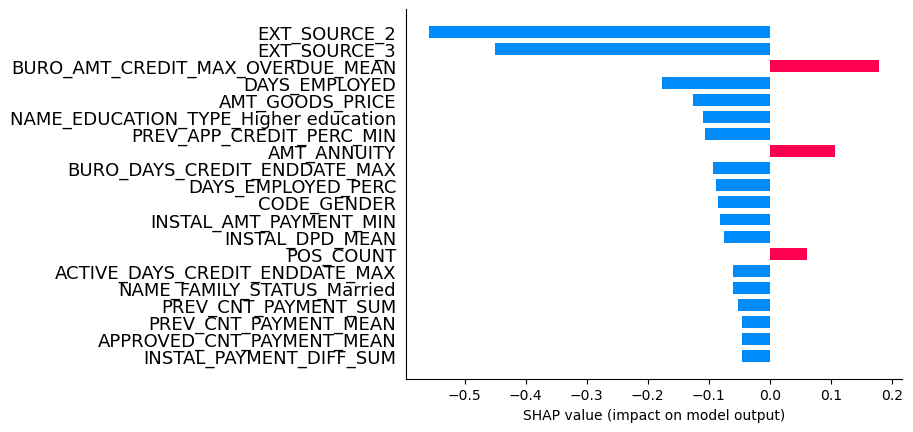

In [129]:
shap.bar_plot(explainer.shap_values(X_test[5]),
              feature_names=X.columns,
              max_display=20)

In [120]:
shap.force_plot(explainer.expected_value,
                explainer.shap_values(X_test[5]),
                feature_names=X.columns,
                out_names="pr√©diction")

In [122]:
# Associer noms et valeurs
for col, val in zip(X.columns, X_test[5]):
    print(f"{col}: {val}")

SK_ID_CURR: 0.12217509229320615
CNT_CHILDREN: -0.5894217207263497
AMT_INCOME_TOTAL: 0.13307988424468067
AMT_CREDIT: 1.4423624473324037
AMT_ANNUITY: 0.7783408005274408
AMT_GOODS_PRICE: 1.1786059104329412
REGION_POPULATION_RELATIVE: 1.9985433187293153
DAYS_BIRTH: -0.8560755615592341
DAYS_EMPLOYED: -4.691938478788894
DAYS_REGISTRATION: -1.827663842312419
DAYS_ID_PUBLISH: 0.07947759949935593
FLAG_MOBIL: 0.0
FLAG_EMP_PHONE: 0.4278366793191026
FLAG_WORK_PHONE: -0.5254087773387821
FLAG_CONT_MOBILE: 0.04332005210594774
FLAG_PHONE: -0.5988623920597015
FLAG_EMAIL: -0.2442841261338073
CNT_FAM_MEMBERS: -0.17642728791916854
REGION_RATING_CLIENT: -2.152210949973332
REGION_RATING_CLIENT_W_CITY: -2.1380412456773357
HOUR_APPR_PROCESS_START: -0.28578352544550767
REG_REGION_NOT_LIVE_REGION: -0.1289433886532155
REG_REGION_NOT_WORK_REGION: -0.2394322970377488
LIVE_REGION_NOT_WORK_REGION: -0.21166304770797895
REG_CITY_NOT_LIVE_CITY: -0.3266159213159415
REG_CITY_NOT_WORK_CITY: -0.6021842759838771
LIVE_CITY_N